# FMCG Sales Data Preprocessing
## Persiapan Data untuk Google Looker

---

## TUJUAN NOTEBOOK

Persiapkan dan transformasikan dataset penjualan FMCG (1.1M baris, 33 kolom) untuk menghasilkan:

1. **Revenue Analysis**: Total penjualan (net_sales) per negara
2. **SKU Performance**: Top 20 SKU berdasarkan revenue
3. **ABC Classification**: Perbandingan kelas ABC (by revenue) per region/country
4. **XYZ Classification**: Identifikasi volatilitas per SKU (Coefficient of Variation pada units_sold)
5. **Correlation Analysis**: Korelasi antara harga (list_price), promosi (promo_flag, discount_pct), dan volume penjualan (units_sold)
6. **Seasonality Patterns**: Visualisasi pola musiman (monthly & weekly trends)

---

## EKSPEKTASI BISNIS / INSIGHT YANG DICARI

| Aspek | Ekspektasi |
|-------|------------|
| **Pola Musiman** | Puncak penjualan yang jelas terlihat (misalnya puncak musim panas/dingin tergantung kategori produk) |
| **Channel Comparison** | E-commerce menunjukkan volatilitas lebih tinggi dibanding channel fisik |
| **Promo Dependency** | Beberapa SKU teridentifikasi bergantung pada promosi (tinggi promo_lift) |
| **Regional Performance** | Identifikasi region berkinerja rendah yang mungkin memerlukan kebijakan safety-stock berbeda |
| **ABC-XYZ Matrix** | Kombinasi klasifikasi untuk strategi inventory optimal |

---

## OUTPUT YANG DIHARAPKAN

### 1. Aggregated Tables (siap untuk Looker)
| Tabel | Deskripsi |
|-------|----------|
| `agg_revenue_by_country` | Total revenue, units, avg_price per negara |
| `agg_revenue_by_sku` | Revenue, units, avg_price, ABC class per SKU |
| `agg_monthly_trend` | Aggregasi bulanan untuk analisis musiman |
| `agg_weekly_trend` | Aggregasi mingguan untuk pola weekday |

### 2. Lookup/Dimension Tables
| Tabel | Deskripsi |
|-------|----------|
| `dim_sku` | SKU ID, name, category, subcategory, brand |
| `dim_store` | Store ID, country, city, channel, coordinates |
| `dim_supplier` | Supplier ID, lead_time_days, purchase_cost |

### 3. Metrik yang Terdefinisi
```
• revenue = SUM(net_sales)
• units = SUM(units_sold)
• avg_price = AVG(list_price)
• promo_lift = (Revenue dengan Promo / Revenue tanpa Promo) - 1
• CV (Coefficient of Variation) = STD(units) / MEAN(units) → untuk XYZ class
• ABC class: A (top 80%), B (next 15%), C (bottom 5%)
• XYZ class: X (CV < 0.5), Y (0.5 ≤ CV < 1), Z (CV ≥ 1)
```

### 4. Artifacts Preprocessing
- File Parquet terpartisi untuk efisiensi query
- Summary statistics untuk validasi

### 5. Visualisasi Validasi (Matplotlib)
- Trend bulanan revenue
- Heatmap korelasi
- Bar chart ABC per region
- Scatter plot promo vs sales

In [1]:
# Import Libraries for Data Analysis
import pandas as pd
import numpy as np
import os

# Additional imports for visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

path = kagglehub.dataset_download("robertocarlost/fmcg-multi-country-sales-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\robertocarlost\fmcg-multi-country-sales-dataset\versions\1


In [4]:
print("Files in dataset:", os.listdir(path))

df = pd.read_csv(os.path.join(path, "fmcg_sales_3years_1M_rows.csv"))
df.head()

Files in dataset: ['fmcg_sales_3years_1M_rows.csv']


,date,year,month,day,weekofyear,weekday,is_weekend,is_holiday,temperature,rain_mm,store_id,country,city,channel,latitude,longitude,sku_id,sku_name,category,subcategory,brand,units_sold,list_price,discount_pct,promo_flag,gross_sales,net_sales,stock_on_hand,stock_out_flag,lead_time_days,supplier_id,purchase_cost,margin_pct
0,2021-01-01,2021,1,1,53,4,0,1,8.44,1.24,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,SKU0086,BrandB Shampoo,Personal Care,Shampoo,BrandB,16,10.49,0.10,1,167.84,151.06,248,0,11,S008,7.53,0.18
1,2021-01-02,2021,1,2,53,5,1,0,12.61,1.12,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,SKU0086,BrandB Shampoo,Personal Care,Shampoo,BrandB,12,10.49,0.00,0,125.88,125.88,238,0,6,S057,5.19,0.51
2,2021-01-03,2021,1,3,53,6,1,0,12.02,2.69,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,SKU0086,BrandB Shampoo,Personal Care,Shampoo,BrandB,38,10.49,0.30,1,398.62,279.03,238,0,6,S017,5.59,0.17
3,2021-01-04,2021,1,4,1,0,0,0,7.76,4.65,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,SKU0086,BrandB Shampoo,Personal Care,Shampoo,BrandB,8,10.49,0.00,0,83.92,83.92,216,0,7,S012,7.81,0.26
4,2021-01-05,2021,1,5,1,1,0,0,11.16,1.77,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,SKU0086,BrandB Shampoo,Personal Care,Shampoo,BrandB,17,10.49,0.20,1,178.33,142.66,372,0,8,S038,7.62,0.07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 33 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            1100000 non-null  object 
 1   year            1100000 non-null  int64  
 2   month           1100000 non-null  int64  
 3   day             1100000 non-null  int64  
 4   weekofyear      1100000 non-null  int64  
 5   weekday         1100000 non-null  int64  
 6   is_weekend      1100000 non-null  int64  
 7   is_holiday      1100000 non-null  int64  
 8   temperature     1100000 non-null  float64
 9   rain_mm         1100000 non-null  float64
 10  store_id        1100000 non-null  object 
 11  country         1100000 non-null  object 
 12  city            1100000 non-null  object 
 13  channel         1100000 non-null  object 
 14  latitude        1100000 non-null  float64
 15  longitude       1100000 non-null  float64
 16  sku_id          1100000 non-null  ob

### **Konversi Tipe Data dan Menambahkan Time-based Feature**
&emsp; Pada tahap ini, kolom tanggal dikonversi dari tipe object menjadi datetime agar data dapat dikenali sebagai informasi waktu, khususnya saat digunakan di Google Looker. Looker tidak dapat memvisualisasikan kolom bertipe object sebagai time-series, sehingga konversi ini penting agar grafik berbasis tanggal (line chart, time trend, monthly performance) dapat ditampilkan dengan benar.

&emsp; Setelah berhasil dikonversi, sistem melakukan validasi seperti mengecek tipe data, tanggal minimum – maksimum, dan rentang harinya. Selanjutnya, beberapa time - based features ditambahkan seperti year_month, quarter, dan weekday_name yang berfungsi untuk memudahkan analisis pola, tren musiman, perilaku mingguan, serta agregasi berdasarkan periode waktu tertentu. Fitur-fitur ini juga sangat berguna dalam pembuatan dashboard di Google Looker karena memungkinkan visualisasi yang lebih fleksibel dan kaya konteks.

In [6]:
# =============================================================================
# DATE CONVERSION & VALIDATION
# =============================================================================

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Verify conversion
print("Date Column Info:")
print(f"  - Dtype: {df['date'].dtype}")
print(f"  - Min Date: {df['date'].min()}")
print(f"  - Max Date: {df['date'].max()}")
print(f"  - Date Range: {(df['date'].max() - df['date'].min()).days} days")
print()

# Create additional time-based columns for analysis
df['year_month'] = df['date'].dt.to_period('M')
df['quarter'] = df['date'].dt.quarter
df['weekday_name'] = df['date'].dt.day_name()

print("Date conversion completed!")
print(f"\nNew columns added: 'year_month', 'quarter', 'weekday_name'")
print(f"\nDataset shape: {df.shape}")
df[['date', 'year', 'month', 'quarter', 'year_month', 'weekday', 'weekday_name']].head()

Date Column Info:
  - Dtype: datetime64[ns]
  - Min Date: 2021-01-01 00:00:00
  - Max Date: 2023-12-31 00:00:00
  - Date Range: 1094 days

Date conversion completed!

New columns added: 'year_month', 'quarter', 'weekday_name'

Dataset shape: (1100000, 36)


,date,year,month,quarter,year_month,weekday,weekday_name
0,2021-01-01,2021,1,1,2021-01,4,Friday
1,2021-01-02,2021,1,1,2021-01,5,Saturday
2,2021-01-03,2021,1,1,2021-01,6,Sunday
3,2021-01-04,2021,1,1,2021-01,0,Monday
4,2021-01-05,2021,1,1,2021-01,1,Tuesday


### **Revenue Analysis**
&emsp; Revenue analysis adalah proses menganalisis performa penjualan berdasarkan data transaksi yang tersedia, seperti nilai penjualan (net_sales), jumlah unit terjual (units_sold), dan harga rata-rata produk (list_price). Pada tahap ini, analisis dilakukan pada level negara, sehingga kita dapat memahami kontribusi masing-masing negara terhadap total pendapatan bisnis.

Pada kode dibawah ini, dilakukan agregasi data menggunakan groupby('country') untuk menghitung beberapa metrik penting:

- total_revenue → total nilai penjualan per negara
- total_units → total unit produk yang berhasil terjual
- avg_price → rata-rata harga produk yang dijual
- transaction_count → jumlah transaksi yang terjadi
- avg_revenue_per_transaction → nilai rata-rata revenue per transaksi

&emsp; Proses ini penting karena revenue analysis membantu mengevaluasi kesehatan finansial bisnis di berbagai wilayah, mengidentifikasi negara dengan kontribusi tertinggi maupun terendah, memahami pola dan tren penjualan, serta merumuskan strategi bisnis yang lebih tepat. Dengan informasi ini, perusahaan dapat mengoptimalkan pemasaran, alokasi stok, strategi ekspansi, serta melakukan prediksi berdasarkan performa historis. Visualisasi yang dihasilkan (bar chart horizontal) juga memudahkan untuk melihat perbandingan revenue antar negara secara intuitif.

TOTAL REVENUE PER COUNTRY
Total Countries: 7
Total Revenue (All): $472,946,452.83



,country,total_revenue,total_units,avg_price,transaction_count,avg_revenue_per_transaction
0,Italy,"137,193,076.12",19361774,7.59,350400,391.53
1,Spain,"106,704,767.04",14668017,7.78,262800,406.03
2,Germany,"88,525,559.01",11738571,7.89,175200,505.28
3,Austria,"43,020,025.97",5742174,7.80,87600,491.10
4,France,"42,601,612.57",6014974,7.46,87600,486.32
5,Poland,"42,385,262.52",5860180,7.65,87600,483.85
6,Netherlands,"12,516,149.60",1730292,8.01,48800,256.48


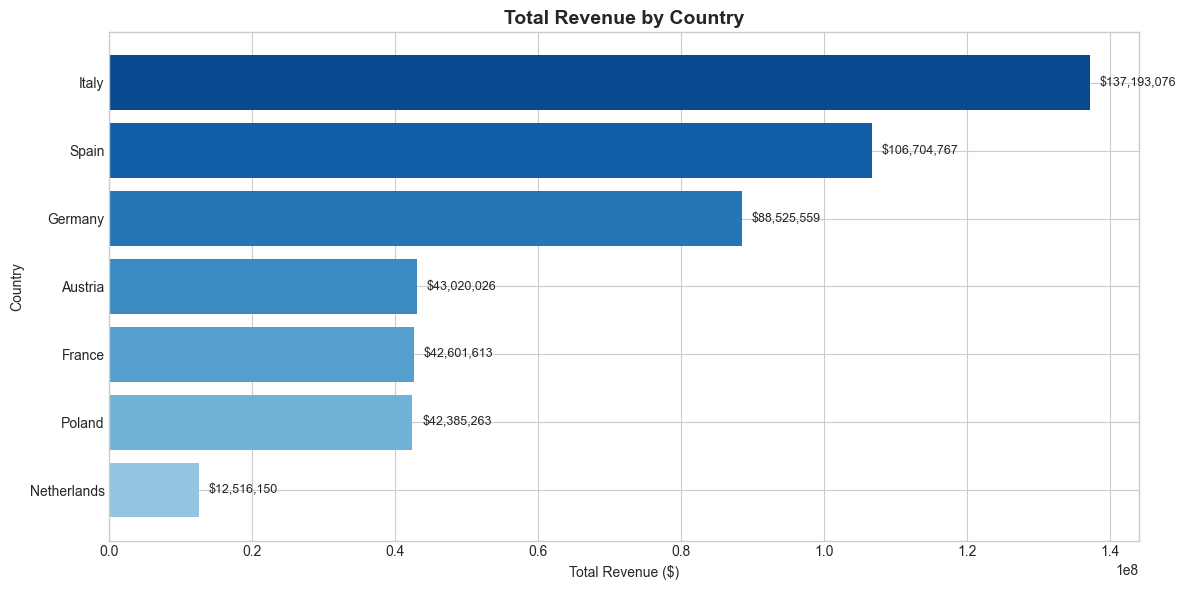


[OK] agg_revenue_by_country table created!


In [7]:
# =============================================================================
# REVENUE ANALYSIS: TOTAL PENJUALAN PER NEGARA
# =============================================================================

# Agregasi revenue per country
agg_revenue_by_country = df.groupby('country').agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    avg_price=('list_price', 'mean'),
    transaction_count=('net_sales', 'count'),
    avg_revenue_per_transaction=('net_sales', 'mean')
).round(2).sort_values('total_revenue', ascending=False).reset_index()

# Display results
print("=" * 60)
print("TOTAL REVENUE PER COUNTRY")
print("=" * 60)
print(f"Total Countries: {len(agg_revenue_by_country)}")
print(f"Total Revenue (All): ${agg_revenue_by_country['total_revenue'].sum():,.2f}")
print()

# Show table
display(agg_revenue_by_country)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(agg_revenue_by_country)))
bars = ax.barh(agg_revenue_by_country['country'], 
               agg_revenue_by_country['total_revenue'], 
               color=colors[::-1])
ax.set_xlabel('Total Revenue ($)')
ax.set_ylabel('Country')
ax.set_title('Total Revenue by Country', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, agg_revenue_by_country['total_revenue']):
    ax.text(val + agg_revenue_by_country['total_revenue'].max() * 0.01, 
            bar.get_y() + bar.get_height()/2,
            f'${val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n[OK] agg_revenue_by_country table created!")

### **Agregasi Revenue per SKU (Stock Keeping Unit)**
&emsp; Agregasi revenue per SKU dilakukan dengan mengelompokkan data berdasarkan sku_id, sku_name, category, dan brand untuk menghitung performa penjualan setiap produk secara lebih spesifik. Pada tahap ini, beberapa metrik penting dihitung, yaitu:

- total_revenue → total penjualan yang dihasilkan oleh SKU
- total_units → total unit yang terjual per SKU
- avg_price → harga rata-rata produk selama periode penjualan
- transaction_count → jumlah transaksi yang melibatkan SKU tersebut

&emsp; Hasil agregasi ini sangat penting karena memungkinkan kita untuk memahami kontribusi masing-masing SKU terhadap total revenue, mengidentifikasi produk dengan performa tertinggi maupun terendah, menganalisis kategori atau brand mana yang paling menguntungkan, serta mendukung pengambilan keputusan seperti perencanaan stok, strategi promosi, dan pengendalian portofolio produk.

&emsp; Pada kode di bawah ini, setelah dilakukan agregasi untuk seluruh SKU, dipilih juga Top 20 SKU berdasarkan total revenue, lalu dihitung persentase kontribusi terhadap total revenue keseluruhan dan cumulative percentage untuk memahami tingkat konsentrasi pendapatan. Visualisasi bar chart horizontal membantu memperlihatkan SKU mana yang menjadi penyumbang terbesar secara intuitif, sehingga memudahkan analisis prioritas dalam manajemen produk dan pengembangan strategi bisnis.

TOP 20 SKU BY REVENUE
Total SKUs in dataset: 102
Top 20 SKU Revenue: $229,414,990.37
Top 20 SKU % of Total: 48.48%



,sku_id,sku_name,category,brand,total_revenue,total_units,avg_price,transaction_count,pct_of_total,cumulative_pct
0,SKU0018,BrandF Water,Beverages,BrandF,"17,032,424.64",1173032,14.52,12045,3.60,3.60
1,SKU0027,BrandC Chips,Snacks,BrandC,"16,000,295.02",1200897,14.15,10950,3.38,6.98
2,SKU0026,BrandB Chips,Snacks,BrandB,"13,025,419.73",893989,14.57,10950,2.75,9.73
3,SKU0099,BrandC Toothpaste,Personal Care,BrandC,"12,968,809.43",1242389,11.16,12045,2.74,12.47
4,SKU0092,BrandB Soap,Personal Care,BrandB,"12,496,995.90",895842,13.95,9855,2.64,15.11
5,SKU0100,BrandD Toothpaste,Personal Care,BrandD,"12,351,150.68",920354,13.42,10950,2.61,17.72
6,SKU0064,BrandD Cheese,Dairy,BrandD,"12,326,994.00",990120,12.45,10950,2.61,20.33
7,SKU0061,BrandA Cheese,Dairy,BrandA,"11,967,260.40",972948,12.30,10950,2.53,22.86
8,SKU0028,BrandD Chips,Snacks,BrandD,"11,749,108.59",1253907,9.37,13140,2.48,25.34
9,SKU0097,BrandA Toothpaste,Personal Care,BrandA,"11,594,508.71",851911,13.61,13140,2.45,27.79


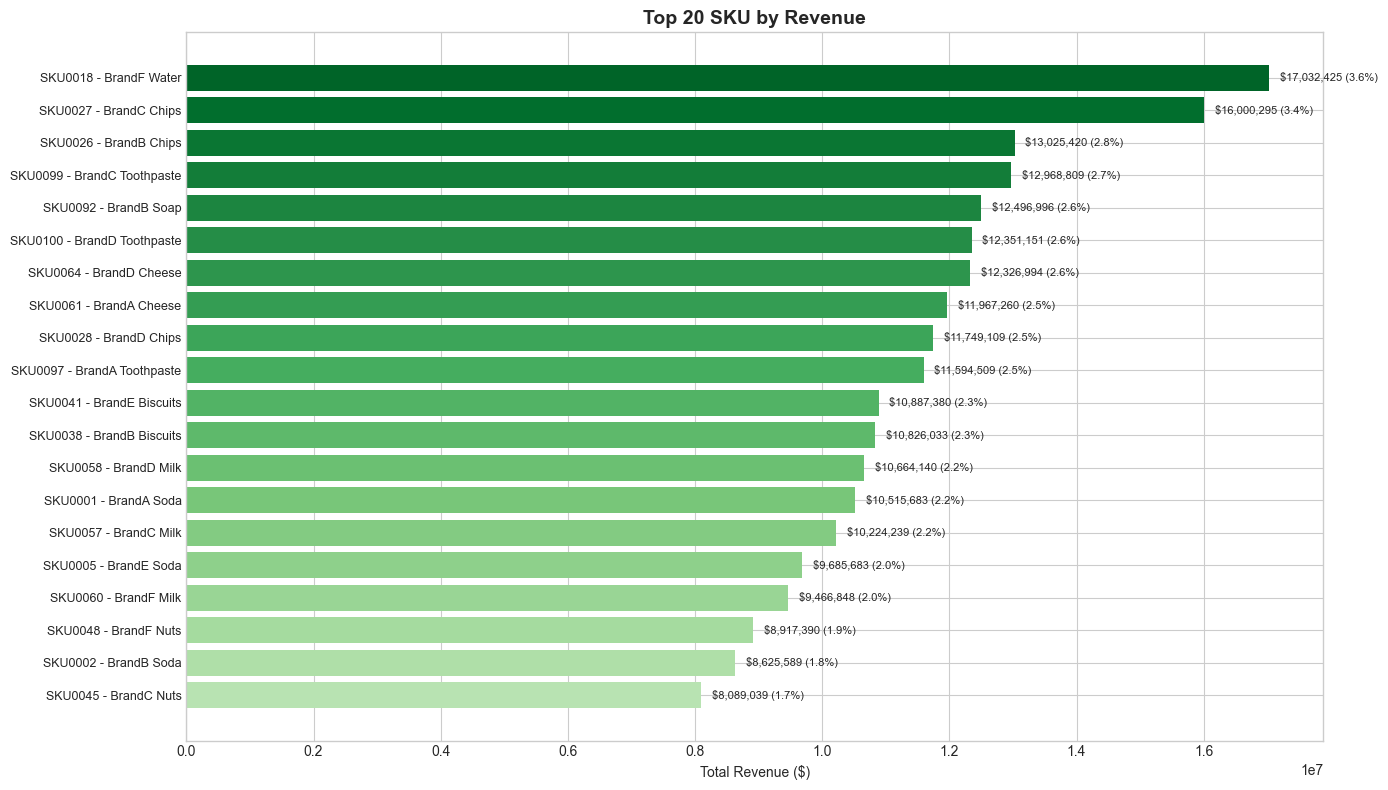


[OK] top_20_sku table created!
[OK] sku_revenue (all 102 SKUs) table also available for further analysis


In [8]:
# Agregasi revenue per SKU
sku_revenue = df.groupby(['sku_id', 'sku_name', 'category', 'brand']).agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    avg_price=('list_price', 'mean'),
    transaction_count=('net_sales', 'count')
).round(2).sort_values('total_revenue', ascending=False).reset_index()

# Get Top 20
top_20_sku = sku_revenue.head(20).copy()

# Calculate percentage of total
total_all_revenue = sku_revenue['total_revenue'].sum()
top_20_sku['pct_of_total'] = (top_20_sku['total_revenue'] / total_all_revenue * 100).round(2)
top_20_sku['cumulative_pct'] = top_20_sku['pct_of_total'].cumsum().round(2)

# Display results
print("=" * 60)
print("TOP 20 SKU BY REVENUE")
print("=" * 60)
print(f"Total SKUs in dataset: {len(sku_revenue)}")
print(f"Top 20 SKU Revenue: ${top_20_sku['total_revenue'].sum():,.2f}")
print(f"Top 20 SKU % of Total: {top_20_sku['pct_of_total'].sum():.2f}%")
print()

# Show table
display(top_20_sku)

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Greens(np.linspace(0.3, 0.9, 20))

# Create labels with SKU name (truncated if too long)
labels = [f"{row['sku_id']} - {row['sku_name'][:20]}..." if len(row['sku_name']) > 20 
          else f"{row['sku_id']} - {row['sku_name']}" 
          for _, row in top_20_sku.iterrows()]

bars = ax.barh(range(20), top_20_sku['total_revenue'], color=colors[::-1])
ax.set_yticks(range(20))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Total Revenue ($)')
ax.set_title('Top 20 SKU by Revenue', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (bar, val, pct) in enumerate(zip(bars, top_20_sku['total_revenue'], top_20_sku['pct_of_total'])):
    ax.text(val + top_20_sku['total_revenue'].max() * 0.01, 
            bar.get_y() + bar.get_height()/2,
            f'${val:,.0f} ({pct:.1f}%)', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n[OK] top_20_sku table created!")
print(f"[OK] sku_revenue (all {len(sku_revenue)} SKUs) table also available for further analysis")

### **ABC Classification berdasarkan Kumulatif Revenue per SKU**
&emsp; ABC Classification adalah metode untuk mengelompokkan SKU berdasarkan kontribusi revenue kumulatifnya terhadap total revenue. Tujuannya adalah mengidentifikasi produk mana yang memberikan dampak terbesar terhadap penjualan, sehingga bisnis dapat fokus pada item bernilai tinggi.

&emsp; Pada implementasi ini, proses klasifikasi dilakukan dengan menghitung persentase revenue tiap SKU, kemudian mengurutkannya secara menurun dan menghitung kumulatif persentase. Berdasarkan nilai kumulatif tersebut, SKU dikelompokkan ke dalam kategori:

- A (High Value Items) → SKU yang secara kumulatif membentuk hingga 80% dari total revenue.
- B (Medium Value Items) → SKU pada kisaran 80%–95% kumulatif revenue.
- C (Low Value Items) → SKU yang masuk pada 5% revenue terbawah (lebih dari 95% kumulatif).

&emsp; Metode ini memanfaatkan prinsip Pareto (80/20 rule), di mana sebagian kecil SKU biasanya menghasilkan porsi terbesar dari revenue total. Dengan demikian, perusahaan dapat memprioritaskan stok, pemasaran, hingga strategi pengelolaan berdasarkan kategori ABC yang terbentuk.

ABC CLASSIFICATION SUMMARY
Total SKUs: 102
Total Revenue: $472,946,452.83



,sku_count,total_revenue,avg_revenue,pct_sku,pct_revenue
abc_class,,,,,
A,49,"375,603,482.14","7,665,377.19",48.04,79.42
B,29,"73,654,127.39","2,539,797.50",28.43,15.57
C,24,"23,688,843.30","987,035.14",23.53,5.01


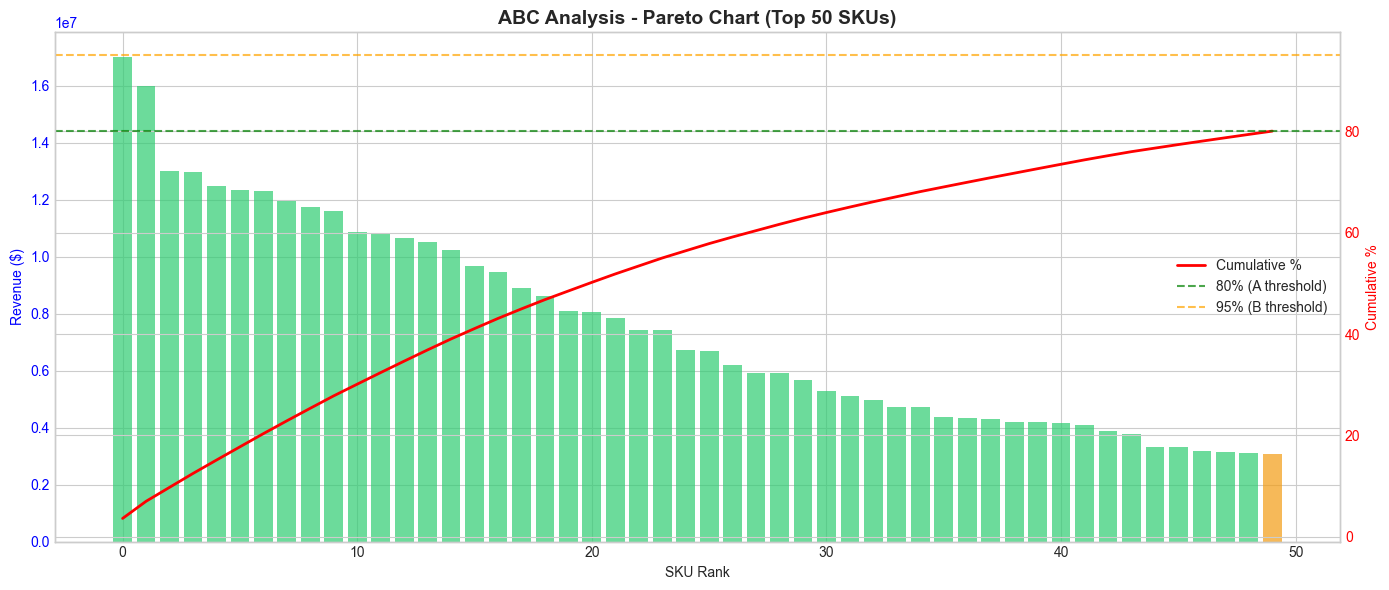

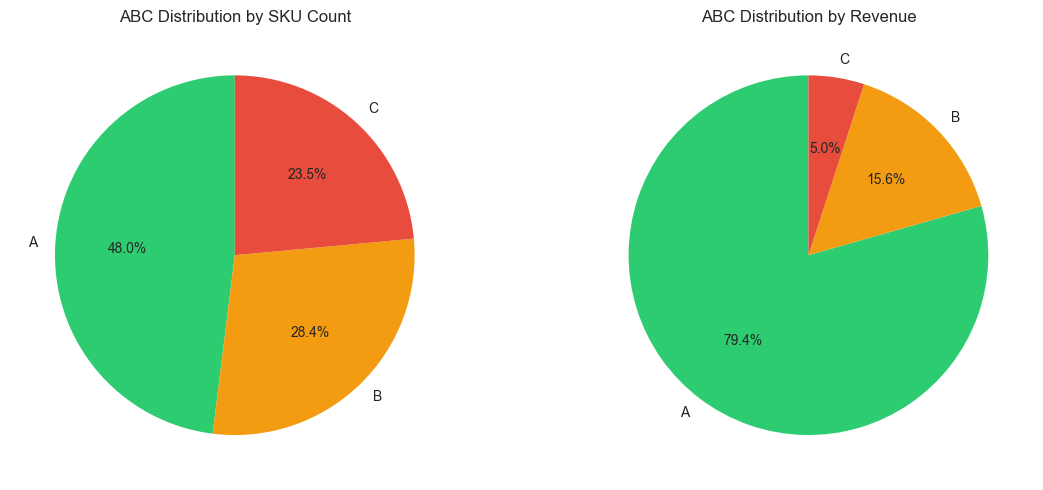


[OK] abc_df table with ABC classification created!


In [9]:
# =============================================================================
# ABC CLASSIFICATION - BERDASARKAN KUMULATIF REVENUE PER SKU
# =============================================================================
# ABC Analysis:
#   A = Top 80% of cumulative revenue (high value items)
#   B = Next 15% of cumulative revenue (medium value items)  
#   C = Bottom 5% of cumulative revenue (low value items)
# =============================================================================

# Use sku_revenue from previous cell (already sorted by revenue descending)
abc_df = sku_revenue.copy()

# Calculate cumulative percentage
total_revenue = abc_df['total_revenue'].sum()
abc_df['revenue_pct'] = (abc_df['total_revenue'] / total_revenue * 100).round(4)
abc_df['cumulative_pct'] = abc_df['revenue_pct'].cumsum().round(4)

# Assign ABC class based on cumulative percentage
def assign_abc_class(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

abc_df['abc_class'] = abc_df['cumulative_pct'].apply(assign_abc_class)

# Summary statistics
abc_summary = abc_df.groupby('abc_class').agg(
    sku_count=('sku_id', 'count'),
    total_revenue=('total_revenue', 'sum'),
    avg_revenue=('total_revenue', 'mean')
).round(2)

abc_summary['pct_sku'] = (abc_summary['sku_count'] / len(abc_df) * 100).round(2)
abc_summary['pct_revenue'] = (abc_summary['total_revenue'] / total_revenue * 100).round(2)

# Display results
print("=" * 60)
print("ABC CLASSIFICATION SUMMARY")
print("=" * 60)
print(f"Total SKUs: {len(abc_df)}")
print(f"Total Revenue: ${total_revenue:,.2f}")
print()
display(abc_summary)

# Visualization - Pareto Chart
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for individual revenue (top 50 SKUs for visibility)
top_n = 50
colors = {'A': '#2ecc71', 'B': '#f39c12', 'C': '#e74c3c'}
bar_colors = [colors[c] for c in abc_df['abc_class'].head(top_n)]

ax1.bar(range(top_n), abc_df['total_revenue'].head(top_n), color=bar_colors, alpha=0.7)
ax1.set_xlabel('SKU Rank')
ax1.set_ylabel('Revenue ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(range(top_n), abc_df['cumulative_pct'].head(top_n), 'r-', linewidth=2, label='Cumulative %')
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% (A threshold)')
ax2.axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% (B threshold)')
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='center right')

plt.title('ABC Analysis - Pareto Chart (Top 50 SKUs)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Pie chart for ABC distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# By SKU count
axes[0].pie(abc_summary['sku_count'], labels=abc_summary.index, autopct='%1.1f%%',
            colors=[colors['A'], colors['B'], colors['C']], startangle=90)
axes[0].set_title('ABC Distribution by SKU Count')

# By Revenue
axes[1].pie(abc_summary['total_revenue'], labels=abc_summary.index, autopct='%1.1f%%',
            colors=[colors['A'], colors['B'], colors['C']], startangle=90)
axes[1].set_title('ABC Distribution by Revenue')

plt.tight_layout()
plt.show()

print("\n[OK] abc_df table with ABC classification created!")

### **XYZ Classification berdasarkan Coefficient of Variation (CV)**
&emsp; XYZ Classification adalah metode analisis persediaan yang mengelompokkan SKU berdasarkan variabilitas permintaan, yaitu seberapa stabil atau fluktuatif jumlah unit yang terjual dari waktu ke waktu. Dalam implementasi ini, tingkat variabilitas permintaan diukur menggunakan Coefficient of Variation (CV), yaitu rasio antara standard deviation dan mean dari penjualan bulanan setiap SKU. Semakin tinggi CV, semakin tidak stabil permintaannya.

&emsp; Pada kode di bawah ini, proses dimulai dengan menghitung total unit terjual per SKU setiap bulan, kemudian dihitung mean, standard deviation, dan akhirnya CV untuk masing-masing SKU. Setelah nilai CV diperoleh, SKU diklasifikasikan ke dalam tiga kategori:

- X (CV < 0.5) → permintaan sangat stabil
- Y (0.5 ≤ CV < 1.0) → permintaan cukup fluktuatif
- Z (CV ≥ 1.0) → permintaan sangat tidak stabil dan sulit diprediksi

&emsp; Klasifikasi ini penting dalam manajemen persediaan karena SKU dengan permintaan stabil (X) cenderung lebih mudah direncanakan stoknya, sedangkan SKU kategori Z membutuhkan strategi khusus seperti safety stock lebih tinggi atau monitoring lebih sering. Kode juga menampilkan ringkasan statistik tiap kelas, contoh SKU dari masing-masing kelas, dan visualisasi berupa histogram distribusi CV serta pie chart proporsi SKU. Dengan demikian, XYZ Classification memberikan gambaran yang jelas tentang pola permintaan yang dapat mendukung pengambilan keputusan inventory dan forecasting secara lebih akurat.

XYZ CLASSIFICATION SUMMARY (Based on Monthly Sales CV)
Total SKUs analyzed: 102
Average CV: 0.107



,sku_count,avg_cv,avg_monthly_units,pct_sku
xyz_class,,,,
X,102,0.11,"17,733.11",100.00



--- Sample SKUs per XYZ Class ---

X Class (Top 3):


,sku_id,sku_name,mean_units,std_units,cv
0,SKU0001,BrandA Soda,"49,788.36","9,780.08",0.20
1,SKU0002,BrandB Soda,"21,297.75","4,266.23",0.20
2,SKU0003,BrandC Soda,"7,010.44","1,374.26",0.20



Y Class (Top 3):


,sku_id,sku_name,mean_units,std_units,cv



Z Class (Top 3):


,sku_id,sku_name,mean_units,std_units,cv


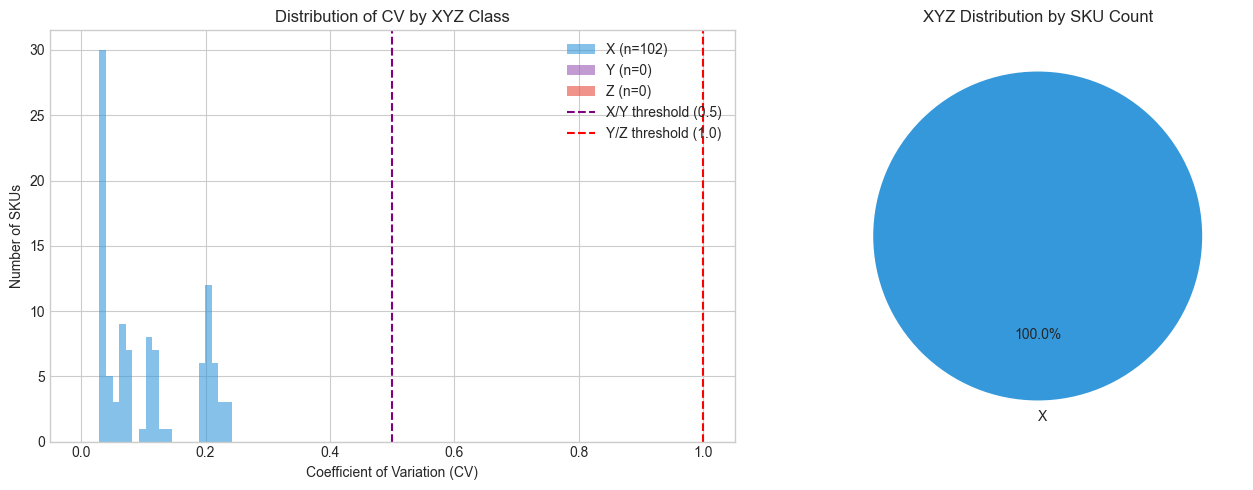


[OK] xyz_df table with XYZ classification created!


In [10]:
# =============================================================================
# XYZ CLASSIFICATION - BERDASARKAN COEFFICIENT OF VARIATION (CV)
# =============================================================================
# XYZ Analysis (Demand Variability):
#   X = CV < 0.5 (Low variability - stable demand)
#   Y = 0.5 <= CV < 1.0 (Medium variability - some fluctuation)
#   Z = CV >= 1.0 (High variability - unpredictable demand)
# CV = Standard Deviation / Mean
# =============================================================================

# Calculate CV per SKU based on monthly sales volume
monthly_sku_sales = df.groupby(['sku_id', 'year_month']).agg(
    monthly_units=('units_sold', 'sum')
).reset_index()

# Calculate mean, std, and CV per SKU
xyz_df = monthly_sku_sales.groupby('sku_id').agg(
    mean_units=('monthly_units', 'mean'),
    std_units=('monthly_units', 'std'),
    months_active=('monthly_units', 'count')
).reset_index()

# Calculate CV (handle division by zero)
xyz_df['cv'] = np.where(
    xyz_df['mean_units'] > 0,
    xyz_df['std_units'] / xyz_df['mean_units'],
    0
).round(4)

# Fill NaN CV with 0 (for SKUs with only 1 month of data)
xyz_df['cv'] = xyz_df['cv'].fillna(0)

# Assign XYZ class
def assign_xyz_class(cv):
    if cv < 0.5:
        return 'X'
    elif cv < 1.0:
        return 'Y'
    else:
        return 'Z'

xyz_df['xyz_class'] = xyz_df['cv'].apply(assign_xyz_class)

# Merge with SKU info
sku_info = df[['sku_id', 'sku_name', 'category', 'brand']].drop_duplicates()
xyz_df = xyz_df.merge(sku_info, on='sku_id', how='left')

# Summary statistics
xyz_summary = xyz_df.groupby('xyz_class').agg(
    sku_count=('sku_id', 'count'),
    avg_cv=('cv', 'mean'),
    avg_monthly_units=('mean_units', 'mean')
).round(3)

xyz_summary['pct_sku'] = (xyz_summary['sku_count'] / len(xyz_df) * 100).round(2)

# Display results
print("=" * 60)
print("XYZ CLASSIFICATION SUMMARY (Based on Monthly Sales CV)")
print("=" * 60)
print(f"Total SKUs analyzed: {len(xyz_df)}")
print(f"Average CV: {xyz_df['cv'].mean():.3f}")
print()
display(xyz_summary)

# Show examples from each class
print("\n--- Sample SKUs per XYZ Class ---")
for cls in ['X', 'Y', 'Z']:
    print(f"\n{cls} Class (Top 3):")
    display(xyz_df[xyz_df['xyz_class'] == cls][['sku_id', 'sku_name', 'mean_units', 'std_units', 'cv']].head(3))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of CV
colors_xyz = {'X': '#3498db', 'Y': '#9b59b6', 'Z': '#e74c3c'}
for cls in ['X', 'Y', 'Z']:
    data = xyz_df[xyz_df['xyz_class'] == cls]['cv']
    axes[0].hist(data, bins=20, alpha=0.6, label=f'{cls} (n={len(data)})', color=colors_xyz[cls])

axes[0].axvline(x=0.5, color='purple', linestyle='--', label='X/Y threshold (0.5)')
axes[0].axvline(x=1.0, color='red', linestyle='--', label='Y/Z threshold (1.0)')
axes[0].set_xlabel('Coefficient of Variation (CV)')
axes[0].set_ylabel('Number of SKUs')
axes[0].set_title('Distribution of CV by XYZ Class')
axes[0].legend()

# Pie chart
axes[1].pie(xyz_summary['sku_count'], labels=xyz_summary.index, autopct='%1.1f%%',
            colors=[colors_xyz['X'], colors_xyz['Y'], colors_xyz['Z']], startangle=90)
axes[1].set_title('XYZ Distribution by SKU Count')

plt.tight_layout()
plt.show()

print("\n[OK] xyz_df table with XYZ classification created!")

### **ABC Classification per Region (Country)**

&emsp;Analisis ini bertujuan untuk memahami bagaimana distribusi ABC Classification tersebar di setiap negara. Dengan menggabungkan kelas ABC ke dalam dataset utama, kita dapat melihat kontribusi revenue, jumlah unit terjual, dan jumlah SKU unik yang termasuk dalam kelas A, B, dan C untuk setiap region. Analisis ini penting untuk mengidentifikasi perbedaan karakteristik produk antar negara—misalnya negara mana yang lebih banyak mengandalkan SKU kelas A (*high value*), atau negara mana yang memiliki distribusi produk yang lebih merata.

Pada *code cell* di bawah ini, dilakukan beberapa langkah utama:

1.  **Penggabungan ABC Class ke dataset asli**
    Menghubungkan `abc_class` dari setiap SKU kembali ke `df` sehingga setiap transaksi memiliki informasi kelas ABC.

2.  **Agregasi ABC per negara**
    Mengelompokkan data berdasarkan `country` dan `abc_class` untuk menghitung:
    * `total_revenue`
    * `total_units`
    * `transaction_count`
    * `unique_skus`
    
    Hasilnya menunjukkan kontribusi tiap kelas ABC dalam sebuah negara.

3.  **Perhitungan persentase revenue per negara**
    Menghitung seberapa besar proporsi revenue dari kelas A, B, dan C dalam konteks total revenue masing-masing negara.

4.  **Pivot Table untuk visualisasi**
    Dibuat dua *pivot table*:
    * `abc_pivot_revenue` → nilai total revenue per kelas.
    * `abc_pivot_pct` → persentase revenue per kelas.
    
    Kedua pivot ini memudahkan analisis dan visualisasi.

5.  **Visualisasi menggunakan Stacked Bar Chart**
    Tersedia dua grafik:
    * **Stacked Bar (Revenue):** Untuk melihat komposisi absolut revenue per kelas.
    * **Stacked Bar (Percentage):** Untuk melihat proporsi (%) distribusi revenue per kelas ABC.

6.  **Insight otomatis**
    Sistem menghitung rata-rata persentase revenue kelas A untuk seluruh negara, lalu mengidentifikasi:
    * Negara yang memiliki proporsi A-class lebih tinggi dari **rata-rata + 5%**.
    * Negara yang memiliki proporsi A-class lebih rendah dari **rata-rata – 5%**.
    
    Insight ini membantu mendeteksi region dengan perilaku pasar atau pola konsumsi yang berbeda dari mayoritas.

&emsp;Analisis ABC per negara ini sangat berguna untuk strategi penjualan, alokasi produk, *inventory planning*, hingga pembuatan kampanye marketing yang lebih ter-target berdasarkan karakteristik pasar tiap region.

ABC DISTRIBUTION PER COUNTRY

--- Revenue by ABC Class per Country ---


abc_class,A,B,C
country,,,
Austria,"33,414,618.51","7,370,217.14","2,235,190.32"
France,"34,409,241.71","5,911,428.00","2,280,942.86"
Germany,"70,941,777.58","13,481,234.31","4,102,547.12"
Italy,"107,530,662.02","22,339,007.19","7,323,406.91"
Netherlands,"10,049,564.12","1,810,121.34","656,464.14"
Poland,"33,855,048.06","6,328,385.35","2,201,829.11"
Spain,"85,402,570.14","16,413,734.06","4,888,462.84"



--- Revenue Percentage by ABC Class per Country ---


abc_class,A,B,C
country,,,
Austria,77.67,17.13,5.20
France,80.77,13.88,5.35
Germany,80.14,15.23,4.63
Italy,78.38,16.28,5.34
Netherlands,80.29,14.46,5.24
Poland,79.87,14.93,5.19
Spain,80.04,15.38,4.58


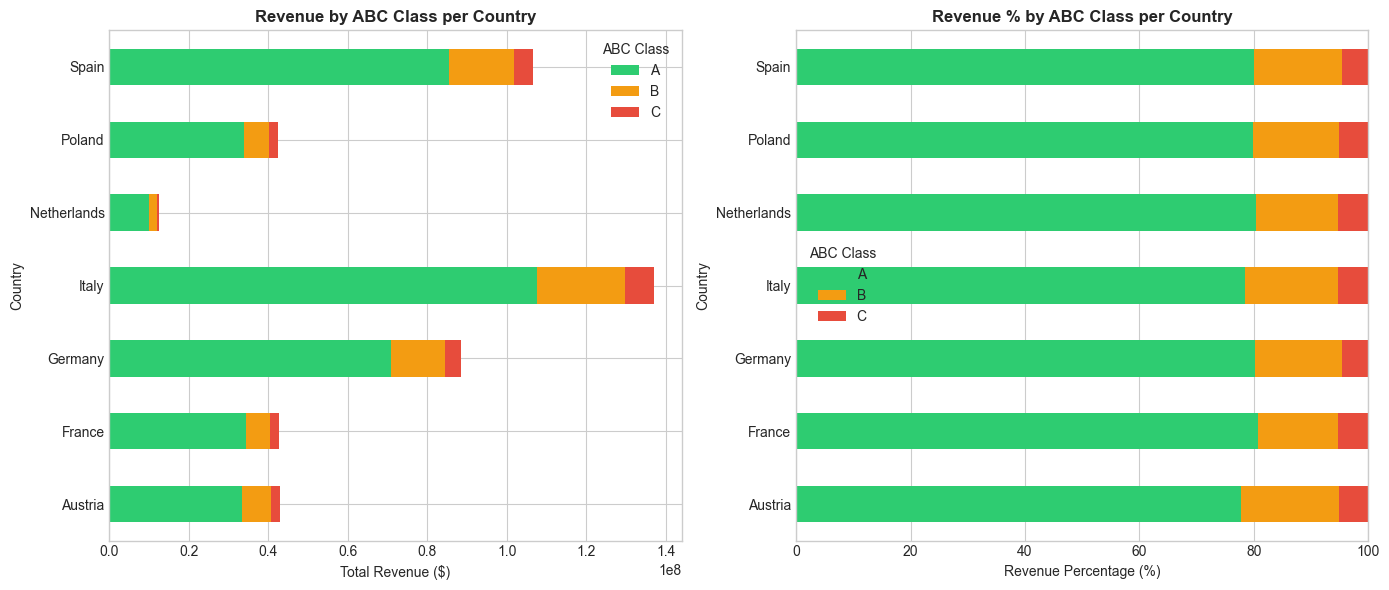


--- Insights ---
Average A-class revenue %: 79.59%

[OK] abc_by_region and pivot tables created!


In [11]:
# =============================================================================
# ABC CLASSIFICATION PER REGION (COUNTRY)
# =============================================================================
# Analisis distribusi ABC class per country untuk identifikasi
# region dengan karakteristik produk berbeda
# =============================================================================

# Merge ABC class back to original dataframe
df_with_abc = df.merge(abc_df[['sku_id', 'abc_class']], on='sku_id', how='left')

# Aggregate by country and ABC class
abc_by_region = df_with_abc.groupby(['country', 'abc_class']).agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    transaction_count=('net_sales', 'count'),
    unique_skus=('sku_id', 'nunique')
).round(2).reset_index()

# Calculate percentage within each country
country_totals = abc_by_region.groupby('country')['total_revenue'].transform('sum')
abc_by_region['revenue_pct'] = (abc_by_region['total_revenue'] / country_totals * 100).round(2)

# Pivot for easier visualization
abc_pivot_revenue = abc_by_region.pivot_table(
    index='country', 
    columns='abc_class', 
    values='total_revenue', 
    fill_value=0
).round(2)

abc_pivot_pct = abc_by_region.pivot_table(
    index='country', 
    columns='abc_class', 
    values='revenue_pct', 
    fill_value=0
).round(2)

# Display results
print("=" * 60)
print("ABC DISTRIBUTION PER COUNTRY")
print("=" * 60)
print("\n--- Revenue by ABC Class per Country ---")
display(abc_pivot_revenue)

print("\n--- Revenue Percentage by ABC Class per Country ---")
display(abc_pivot_pct)

# Visualization - Stacked Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'A': '#2ecc71', 'B': '#f39c12', 'C': '#e74c3c'}

# Stacked bar - Revenue
abc_pivot_revenue[['A', 'B', 'C']].plot(
    kind='barh', 
    stacked=True, 
    ax=axes[0],
    color=[colors['A'], colors['B'], colors['C']]
)
axes[0].set_xlabel('Total Revenue ($)')
axes[0].set_ylabel('Country')
axes[0].set_title('Revenue by ABC Class per Country', fontweight='bold')
axes[0].legend(title='ABC Class')

# Stacked bar - Percentage (normalized)
abc_pivot_pct[['A', 'B', 'C']].plot(
    kind='barh', 
    stacked=True, 
    ax=axes[1],
    color=[colors['A'], colors['B'], colors['C']]
)
axes[1].set_xlabel('Revenue Percentage (%)')
axes[1].set_ylabel('Country')
axes[1].set_title('Revenue % by ABC Class per Country', fontweight='bold')
axes[1].legend(title='ABC Class')
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Identify regions with unusual ABC distribution
print("\n--- Insights ---")
avg_a_pct = abc_pivot_pct['A'].mean()
high_a_countries = abc_pivot_pct[abc_pivot_pct['A'] > avg_a_pct + 5].index.tolist()
low_a_countries = abc_pivot_pct[abc_pivot_pct['A'] < avg_a_pct - 5].index.tolist()

print(f"Average A-class revenue %: {avg_a_pct:.2f}%")
if high_a_countries:
    print(f"Countries with HIGH A-class concentration: {high_a_countries}")
if low_a_countries:
    print(f"Countries with LOW A-class concentration: {low_a_countries}")

print("\n[OK] abc_by_region and pivot tables created!")

### Correlation Analysis
&emsp; Analisis korelasi adalah metode statistik yang digunakan untuk mengukur seberapa kuat dan ke arah mana hubungan antara dua variabel. Dalam konteks analisis performa penjualan, korelasi membantu memahami bagaimana perubahan pada variabel seperti harga, diskon, atau promo dapat berhubungan dengan perubahan volume penjualan maupun revenue.

Pada bagian ini, analisis dilakukan terhadap beberapa variabel penting, yaitu:

- list_price — harga jual awal (tanpa diskon)
- discount_pct — persentase diskon yang diberikan
- promo_flag — indikator apakah produk sedang promo (1) atau tidak (0)
- units_sold — jumlah unit terjual
- net_sales — pendapatan bersih setelah diskon
- gross_sales — pendapatan kotor sebelum diskon
- margin_pct — margin keuntungan dalam persen

Tujuan dari analisis ini adalah untuk mengidentifikasi pola hubungan, misalnya:

- apakah harga berpengaruh terhadap volume penjualan,
- apakah diskon efektif meningkatkan unit terjual,
- apakah promo flag berkorelasi dengan revenue,
- serta bagaimana variabel-variabel keuangan saling memengaruhi.

Pada code cell, dilakukan langkah-langkah berikut:

- Pemilihan variabel untuk dianalisis dalam correlation matrix.
- Perhitungan matriks korelasi menggunakan .corr() dan pembulatan 3 desimal.
- Visualisasi heatmap untuk memudahkan interpretasi hubungan antar variabel.
- Pencetakan insight utama untuk hubungan-hubungan penting seperti price vs units sold, discount vs units sold, dan promo vs units sold.
- Visualisasi scatter plot dan box plot untuk melihat pola hubungan secara lebih jelas.

&emsp; Dengan pendekatan ini, analisis korelasi membantu mengungkap variabel mana yang memiliki hubungan kuat dan relevan dalam memengaruhi performa penjualan, sehingga dapat menjadi dasar pengambilan keputusan bisnis yang lebih akurat dan data-driven.

CORRELATION MATRIX


,list_price,discount_pct,promo_flag,units_sold,net_sales,gross_sales,margin_pct
list_price,1.00,-0.04,-0.05,-0.08,0.58,0.56,0.02
discount_pct,-0.04,1.00,0.93,0.29,0.08,0.17,-0.54
promo_flag,-0.05,0.93,1.00,0.30,0.09,0.17,-0.49
units_sold,-0.08,0.29,0.30,1.00,0.63,0.65,-0.16
net_sales,0.58,0.08,0.09,0.63,1.00,0.99,-0.04
gross_sales,0.56,0.17,0.17,0.65,0.99,1.00,-0.09
margin_pct,0.02,-0.54,-0.49,-0.16,-0.04,-0.09,1.00


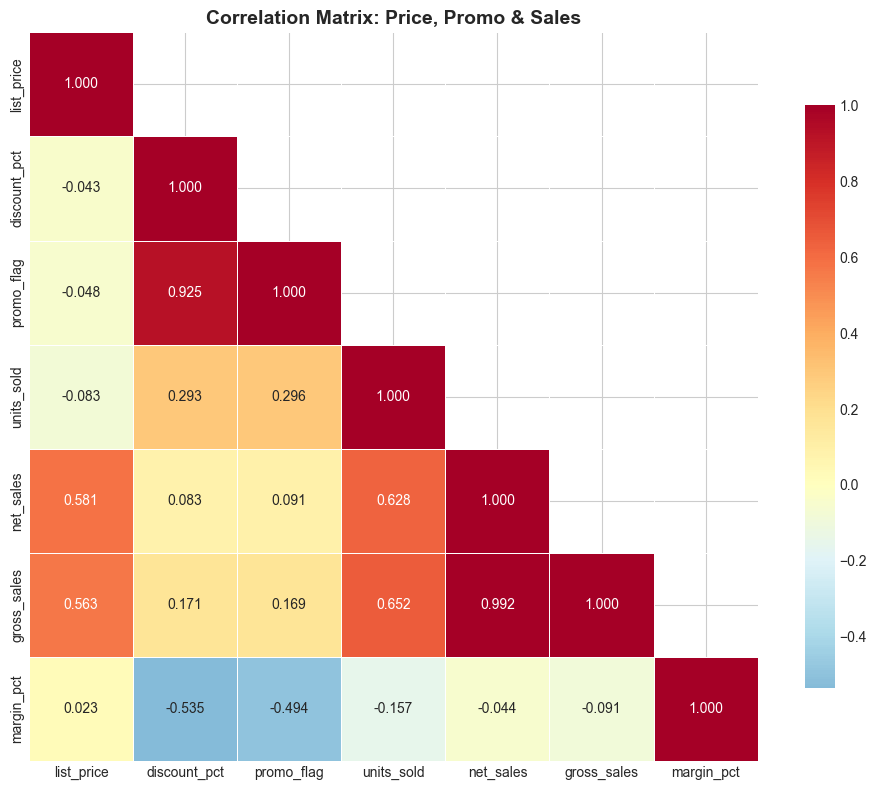


--- Key Correlations ---
Price vs Units Sold: -0.083
Discount % vs Units Sold: 0.293
Promo Flag vs Units Sold: 0.296
Promo Flag vs Discount %: 0.925


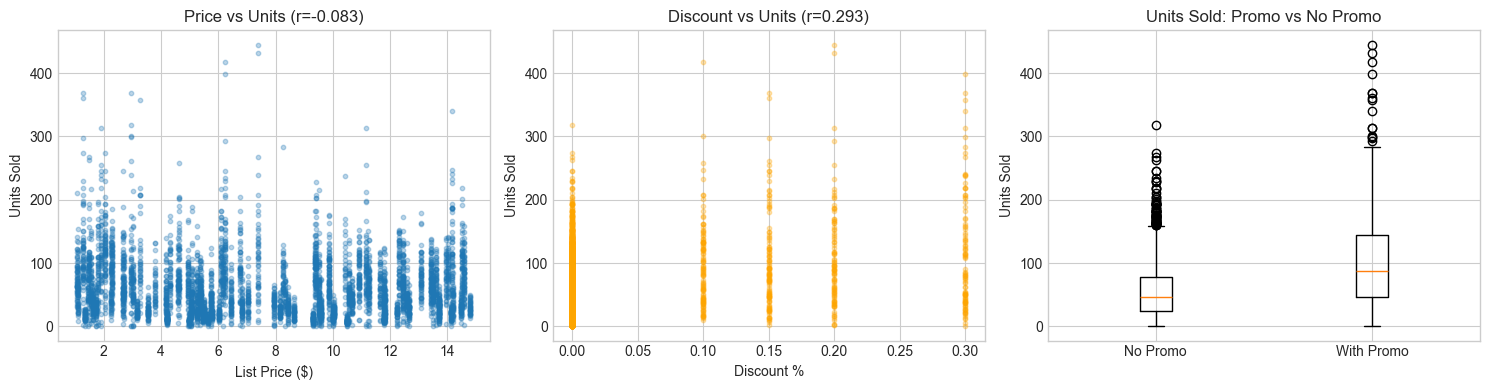


[OK] correlation_matrix created!


In [12]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
# Analisis korelasi antara:
#   - list_price (harga)
#   - discount_pct (persentase diskon)
#   - promo_flag (flag promosi)
#   - units_sold (volume penjualan)
#   - net_sales (revenue)
# =============================================================================

# Select columns for correlation
corr_columns = ['list_price', 'discount_pct', 'promo_flag', 'units_sold', 
                'net_sales', 'gross_sales', 'margin_pct']

# Calculate correlation matrix
correlation_matrix = df[corr_columns].corr().round(3)

# Display correlation matrix
print("=" * 60)
print("CORRELATION MATRIX")
print("=" * 60)
display(correlation_matrix)

# Visualization - Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0,
            mask=mask,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            ax=ax)

ax.set_title('Correlation Matrix: Price, Promo & Sales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key insights
print("\n--- Key Correlations ---")
print(f"Price vs Units Sold: {correlation_matrix.loc['list_price', 'units_sold']:.3f}")
print(f"Discount % vs Units Sold: {correlation_matrix.loc['discount_pct', 'units_sold']:.3f}")
print(f"Promo Flag vs Units Sold: {correlation_matrix.loc['promo_flag', 'units_sold']:.3f}")
print(f"Promo Flag vs Discount %: {correlation_matrix.loc['promo_flag', 'discount_pct']:.3f}")

# Scatter plots for key relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sample data for faster plotting (if dataset is large)
sample_df = df.sample(n=min(5000, len(df)), random_state=42)

# Price vs Units
axes[0].scatter(sample_df['list_price'], sample_df['units_sold'], alpha=0.3, s=10)
axes[0].set_xlabel('List Price ($)')
axes[0].set_ylabel('Units Sold')
axes[0].set_title(f'Price vs Units (r={correlation_matrix.loc["list_price", "units_sold"]:.3f})')

# Discount vs Units
axes[1].scatter(sample_df['discount_pct'], sample_df['units_sold'], alpha=0.3, s=10, color='orange')
axes[1].set_xlabel('Discount %')
axes[1].set_ylabel('Units Sold')
axes[1].set_title(f'Discount vs Units (r={correlation_matrix.loc["discount_pct", "units_sold"]:.3f})')

# Promo vs Units (box plot)
promo_0 = sample_df[sample_df['promo_flag'] == 0]['units_sold']
promo_1 = sample_df[sample_df['promo_flag'] == 1]['units_sold']
axes[2].boxplot([promo_0, promo_1], labels=['No Promo', 'With Promo'])
axes[2].set_ylabel('Units Sold')
axes[2].set_title('Units Sold: Promo vs No Promo')

plt.tight_layout()
plt.show()

print("\n[OK] correlation_matrix created!")

### Promo Lift Analysis
&emsp; Promo lift adalah metrik yang digunakan untuk mengukur seberapa besar peningkatan penjualan yang terjadi akibat adanya promosi, dibandingkan dengan kondisi tanpa promosi. Analisis ini penting untuk mengevaluasi apakah promo benar-benar memberikan dampak positif terhadap pendapatan maupun volume penjualan.

Secara umum, promo lift dihitung dengan rumus:
    **Promo Lift = (Penjualan Saat Promo / Penjualan Tanpa Promo) − 1**

&emsp; Nilai lift yang positif berarti promo berhasil meningkatkan performa, sedangkan nilai negatif menunjukkan bahwa promo tidak memberi dampak signifikan atau bahkan menurunkan performa.

Pada analisis ini dilakukan beberapa langkah:
- Menghitung metrik penjualan berdasarkan promo_flag, seperti total revenue, total units sold, rata-rata unit per transaksi, rata-rata revenue per transaksi, dan rata-rata diskon.
- Menghitung Promo Lift secara keseluruhan, baik dari sisi revenue maupun units per transaction.
- Menghitung Promo Lift per kategori produk, untuk melihat kategori mana yang paling responsif terhadap promo.
- Visualisasi menggunakan bar plot dan horizontal bar chart, sehingga perbedaan dengan dan tanpa promo dapat terlihat dengan jelas.
- Mengidentifikasi kategori dengan promo dependency tinggi, yaitu kategori yang mendapatkan peningkatan revenue signifikan (>10%) saat diberikan promo.
- Menandai kategori dengan promo lift negatif, sebagai indikasi bahwa promo kurang efektif di kategori tersebut.

&emsp; Dengan analisis ini, kita dapat memahami efektivitas strategi promosi secara lebih komprehensif, mengetahui kategori mana yang sebaiknya sering diberikan promo, serta menghindari promo yang tidak memberikan dampak positif bagi revenue perusahaan.

PROMO LIFT ANALYSIS


,total_revenue,total_units,avg_units_per_transaction,avg_revenue_per_transaction,transaction_count,avg_discount
No Promo,"423,547,595.80",55913638,55.26,418.63,1011743,0.00
With Promo,"49,398,857.03",9202344,104.27,559.72,88257,0.19



--- PROMO LIFT METRICS ---
Revenue Lift: -88.34%
Units/Transaction Lift: 88.69%

--- PROMO LIFT BY CATEGORY ---


,revenue_lift,units_lift
category,,
Snacks,-0.84,0.67
Beverages,-0.85,1.05
Home Care,-0.87,1.31
Personal Care,-0.92,0.67
Dairy,-0.96,0.64


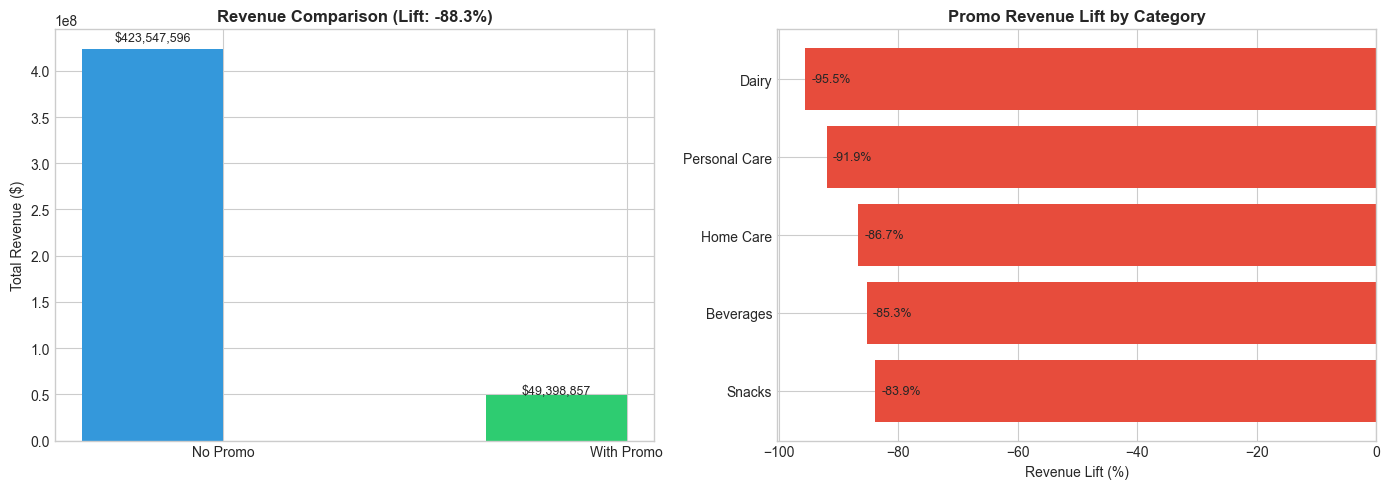


--- INSIGHTS ---
Categories with NEGATIVE promo lift: ['Snacks', 'Beverages', 'Home Care', 'Personal Care', 'Dairy']

[OK] promo_analysis and promo_lift_by_cat tables created!


In [13]:
# =============================================================================
# PROMO LIFT ANALYSIS
# =============================================================================
# Promo Lift = (Revenue dengan Promo / Revenue tanpa Promo) - 1
# Mengukur efektivitas promosi dalam meningkatkan penjualan
# =============================================================================

# Overall promo analysis
promo_analysis = df.groupby('promo_flag').agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    avg_units_per_transaction=('units_sold', 'mean'),
    avg_revenue_per_transaction=('net_sales', 'mean'),
    transaction_count=('net_sales', 'count'),
    avg_discount=('discount_pct', 'mean')
).round(2)

promo_analysis.index = ['No Promo', 'With Promo']

# Calculate lift metrics
revenue_no_promo = promo_analysis.loc['No Promo', 'total_revenue']
revenue_with_promo = promo_analysis.loc['With Promo', 'total_revenue']
units_no_promo = promo_analysis.loc['No Promo', 'avg_units_per_transaction']
units_with_promo = promo_analysis.loc['With Promo', 'avg_units_per_transaction']

# Calculate lift
promo_lift_revenue = (revenue_with_promo / revenue_no_promo) - 1
promo_lift_units = (units_with_promo / units_no_promo) - 1

# Display results
print("=" * 60)
print("PROMO LIFT ANALYSIS")
print("=" * 60)
display(promo_analysis)

print(f"\n--- PROMO LIFT METRICS ---")
print(f"Revenue Lift: {promo_lift_revenue:.2%}")
print(f"Units/Transaction Lift: {promo_lift_units:.2%}")

# Promo lift by category
promo_by_category = df.groupby(['category', 'promo_flag']).agg(
    total_revenue=('net_sales', 'sum'),
    avg_units=('units_sold', 'mean')
).round(2).unstack()

# Calculate lift per category
promo_lift_by_cat = pd.DataFrame({
    'revenue_no_promo': promo_by_category[('total_revenue', 0)],
    'revenue_with_promo': promo_by_category[('total_revenue', 1)],
    'units_no_promo': promo_by_category[('avg_units', 0)],
    'units_with_promo': promo_by_category[('avg_units', 1)]
})

promo_lift_by_cat['revenue_lift'] = ((promo_lift_by_cat['revenue_with_promo'] / 
                                       promo_lift_by_cat['revenue_no_promo']) - 1).round(4)
promo_lift_by_cat['units_lift'] = ((promo_lift_by_cat['units_with_promo'] / 
                                     promo_lift_by_cat['units_no_promo']) - 1).round(4)

promo_lift_by_cat = promo_lift_by_cat.sort_values('revenue_lift', ascending=False)

print("\n--- PROMO LIFT BY CATEGORY ---")
display(promo_lift_by_cat[['revenue_lift', 'units_lift']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall promo comparison
x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, [revenue_no_promo, revenue_with_promo], width, 
            label='Total Revenue', color=['#3498db', '#2ecc71'])
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Promo', 'With Promo'])
axes[0].set_ylabel('Total Revenue ($)')
axes[0].set_title(f'Revenue Comparison (Lift: {promo_lift_revenue:.1%})', fontweight='bold')

# Add value labels
for i, v in enumerate([revenue_no_promo, revenue_with_promo]):
    axes[0].text(i - width/2, v + v*0.02, f'${v:,.0f}', ha='center', fontsize=9)

# Promo lift by category
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in promo_lift_by_cat['revenue_lift']]
axes[1].barh(promo_lift_by_cat.index, promo_lift_by_cat['revenue_lift'] * 100, color=colors)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Revenue Lift (%)')
axes[1].set_title('Promo Revenue Lift by Category', fontweight='bold')

# Add value labels
for i, (idx, val) in enumerate(zip(promo_lift_by_cat.index, promo_lift_by_cat['revenue_lift'])):
    axes[1].text(val * 100 + 1, i, f'{val:.1%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Identify promo-dependent SKUs (high lift)
print("\n--- INSIGHTS ---")
high_lift_cats = promo_lift_by_cat[promo_lift_by_cat['revenue_lift'] > 0.1].index.tolist()
low_lift_cats = promo_lift_by_cat[promo_lift_by_cat['revenue_lift'] < 0].index.tolist()

if high_lift_cats:
    print(f"Categories with HIGH promo dependency (>10% lift): {high_lift_cats}")
if low_lift_cats:
    print(f"Categories with NEGATIVE promo lift: {low_lift_cats}")

print("\n[OK] promo_analysis and promo_lift_by_cat tables created!")

### Monthly Trend Analysis
&emsp; Analisis tren bulanan digunakan untuk memahami bagaimana performa penjualan berubah dari bulan ke bulan, baik dalam satu tahun maupun lintas tahun. Dengan melihat pola musiman (seasonality), kita dapat mengidentifikasi kapan penjualan mencapai puncak (peak), mengalami penurunan (valley), atau menunjukkan pola tertentu seperti peningkatan stabil, lonjakan musiman, atau anomali.

Pada analisis ini, beberapa langkah dilakukan untuk menggambarkan tren bulanan secara komprehensif:
- Agregasi data per bulan berdasarkan year dan month, mencakup total revenue, total units sold, rata-rata harga, jumlah transaksi, dan rata-rata tingkat promosi.
- Pembuatan label year–month untuk memudahkan visualisasi dalam bentuk deret waktu.
- Visualisasi tren revenue bulanan menggunakan line chart. Grafik ini menampilkan pola naik-turun revenue selama periode analisis, sekaligus menandai bulan dengan nilai tertinggi (peak) dan terendah (valley).
- Visualisasi tren jumlah unit terjual menggunakan bar chart, memberikan gambaran volume penjualan bulanan secara lebih intuitif.
- Perhitungan rata-rata bulanan lintas tahun, yang menghasilkan "seasonal revenue index". Index ini menunjukkan apakah suatu bulan memiliki performa di atas atau di bawah rata-rata tahunan (100 = rata-rata).
- Visualisasi pola musiman (seasonality) dengan revenue index, untuk melihat bulan mana yang secara konsisten kuat atau lemah dalam penjualan.
- Identifikasi bulan puncak dan lembah secara musiman, serta menghitung rentang variabilitas antar bulan.

&emsp; Dengan analisis tren bulanan ini, kita dapat memahami siklus musiman penjualan, mengantisipasi permintaan, mengoptimalkan inventori, serta merencanakan aktivitas marketing/promosi pada bulan-bulan yang tepat.

MONTHLY TREND ANALYSIS
Period: 2021-01 to 2023-12
Total Months: 36



,year,month,total_revenue,total_units,avg_price,transaction_count,promo_rate,year_month_label
0,2021,1,"13,146,751.83",1820815,7.71,31155,0.09,2021-01
1,2021,2,"11,837,396.87",1627648,7.71,28140,0.08,2021-02
2,2021,3,"12,740,242.56",1746833,7.71,31155,0.08,2021-03
3,2021,4,"12,385,409.98",1695518,7.71,30150,0.09,2021-04
4,2021,5,"12,915,862.11",1766192,7.71,31155,0.09,2021-05
5,2021,6,"13,540,282.62",1883342,7.71,30150,0.08,2021-06
6,2021,7,"14,119,906.33",1978893,7.71,31155,0.09,2021-07
7,2021,8,"14,169,765.05",2002722,7.71,31155,0.09,2021-08
8,2021,9,"12,414,988.06",1684090,7.71,30150,0.08,2021-09
9,2021,10,"12,924,691.93",1766916,7.71,31155,0.08,2021-10


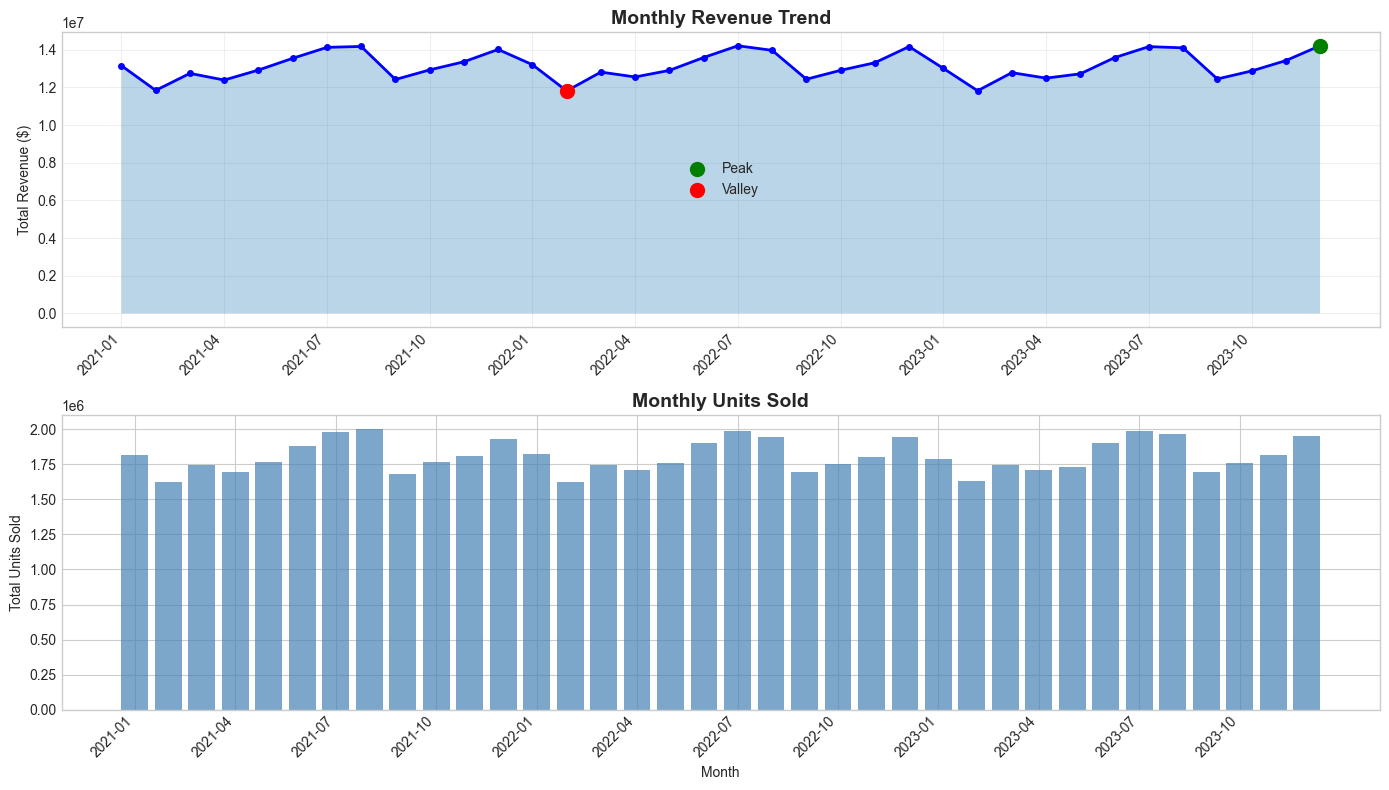

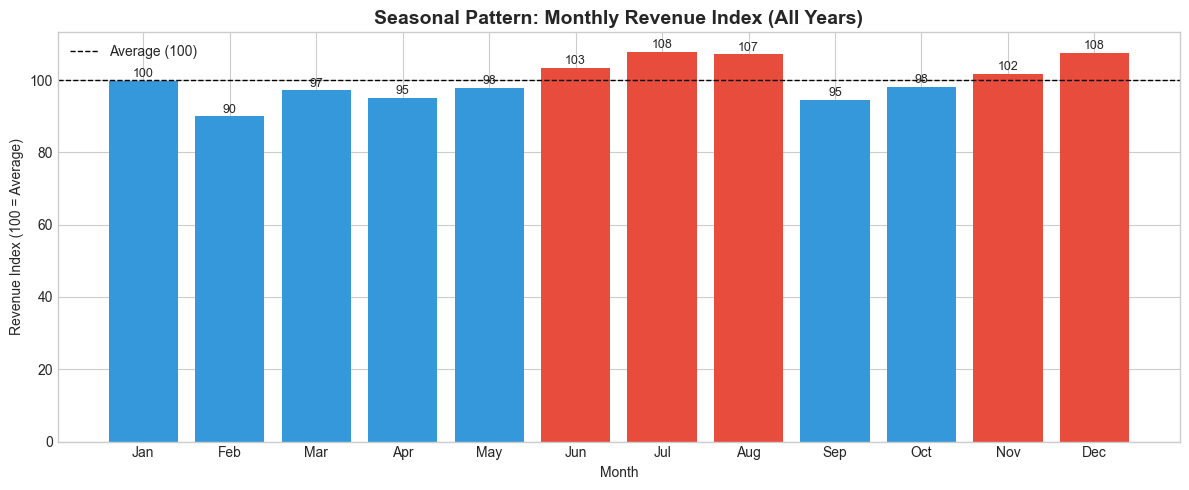


--- SEASONALITY INSIGHTS ---
Peak Month: Jul (Index: 107.8)
Valley Month: Feb (Index: 90.0)
Seasonality Range: 17.8 points

[OK] agg_monthly_trend table created!


In [14]:
# =============================================================================
# MONTHLY TREND ANALYSIS
# =============================================================================
# Analisis pola musiman berdasarkan agregasi bulanan
# Mengidentifikasi puncak dan lembah penjualan sepanjang tahun
# =============================================================================

# Agregasi per bulan
agg_monthly_trend = df.groupby(['year', 'month']).agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    avg_price=('list_price', 'mean'),
    transaction_count=('net_sales', 'count'),
    promo_rate=('promo_flag', 'mean')
).round(2).reset_index()

# Create year-month label
agg_monthly_trend['year_month_label'] = agg_monthly_trend['year'].astype(str) + '-' + \
                                         agg_monthly_trend['month'].astype(str).str.zfill(2)

# Display results
print("=" * 60)
print("MONTHLY TREND ANALYSIS")
print("=" * 60)
print(f"Period: {agg_monthly_trend['year_month_label'].min()} to {agg_monthly_trend['year_month_label'].max()}")
print(f"Total Months: {len(agg_monthly_trend)}")
print()
display(agg_monthly_trend.head(12))

# Visualization - Time Series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Revenue trend
axes[0].plot(range(len(agg_monthly_trend)), agg_monthly_trend['total_revenue'], 
             'b-', linewidth=2, marker='o', markersize=4)
axes[0].fill_between(range(len(agg_monthly_trend)), agg_monthly_trend['total_revenue'], 
                     alpha=0.3)
axes[0].set_xticks(range(0, len(agg_monthly_trend), 3))
axes[0].set_xticklabels(agg_monthly_trend['year_month_label'].iloc[::3], rotation=45, ha='right')
axes[0].set_ylabel('Total Revenue ($)')
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Mark peaks and valleys
peak_idx = agg_monthly_trend['total_revenue'].idxmax()
valley_idx = agg_monthly_trend['total_revenue'].idxmin()
axes[0].scatter([peak_idx], [agg_monthly_trend.loc[peak_idx, 'total_revenue']], 
                color='green', s=100, zorder=5, label='Peak')
axes[0].scatter([valley_idx], [agg_monthly_trend.loc[valley_idx, 'total_revenue']], 
                color='red', s=100, zorder=5, label='Valley')
axes[0].legend()

# Units trend
axes[1].bar(range(len(agg_monthly_trend)), agg_monthly_trend['total_units'], 
            color='steelblue', alpha=0.7)
axes[1].set_xticks(range(0, len(agg_monthly_trend), 3))
axes[1].set_xticklabels(agg_monthly_trend['year_month_label'].iloc[::3], rotation=45, ha='right')
axes[1].set_ylabel('Total Units Sold')
axes[1].set_xlabel('Month')
axes[1].set_title('Monthly Units Sold', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Monthly average (across all years)
monthly_avg = df.groupby('month').agg(
    avg_revenue=('net_sales', 'sum'),
    avg_units=('units_sold', 'sum')
).reset_index()

# Normalize to show relative pattern
monthly_avg['revenue_index'] = (monthly_avg['avg_revenue'] / monthly_avg['avg_revenue'].mean() * 100).round(1)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#e74c3c' if x > 100 else '#3498db' for x in monthly_avg['revenue_index']]
bars = ax.bar(month_names, monthly_avg['revenue_index'], color=colors)
ax.axhline(y=100, color='black', linestyle='--', linewidth=1, label='Average (100)')
ax.set_ylabel('Revenue Index (100 = Average)')
ax.set_xlabel('Month')
ax.set_title('Seasonal Pattern: Monthly Revenue Index (All Years)', fontsize=14, fontweight='bold')
ax.legend()

# Add value labels
for bar, val in zip(bars, monthly_avg['revenue_index']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Insights
print("\n--- SEASONALITY INSIGHTS ---")
peak_month = month_names[monthly_avg['revenue_index'].idxmax()]
valley_month = month_names[monthly_avg['revenue_index'].idxmin()]
print(f"Peak Month: {peak_month} (Index: {monthly_avg['revenue_index'].max():.1f})")
print(f"Valley Month: {valley_month} (Index: {monthly_avg['revenue_index'].min():.1f})")
print(f"Seasonality Range: {monthly_avg['revenue_index'].max() - monthly_avg['revenue_index'].min():.1f} points")

print("\n[OK] agg_monthly_trend table created!")

### Weekly Pattern Analysis
&emsp; Weekly Pattern Analysis digunakan untuk memahami bagaimana perilaku penjualan berubah berdasarkan hari dalam seminggu. Dengan menganalisis pola mingguan, kita dapat mengidentifikasi hari mana yang cenderung memiliki penjualan tertinggi, hari yang lemah, serta perbedaan pola antara hari kerja (weekday) dan akhir minggu (weekend).

Analisis ini dilakukan dengan beberapa langkah utama:
- Mengagregasi data berdasarkan hari dalam seminggu (weekday dan weekday_name).
Proses ini menghasilkan metrik seperti total revenue, total units sold, rata-rata revenue per transaksi, serta jumlah transaksi per hari.
- Mengurutkan hari berdasarkan urutan kalender (Senin → Minggu) untuk memastikan visualisasi dan interpretasi yang konsisten.
- Menghitung Revenue Index, yaitu perbandingan revenue harian terhadap rata-rata seluruh hari (100 = rata-rata). Revenue Index ini membantu melihat dengan cepat hari mana yang performanya berada di atas atau di bawah ekspektasi normal.

Membuat dua visualisasi utama:
- Grafik total revenue harian (membedakan weekday dan weekend).
- Grafik revenue index harian (memberi highlight performa di atas/bawah rata-rata).
- Menganalisis perbedaan kinerja antara weekday dan weekend, termasuk total revenue, rata-rata revenue per transaksi, serta rasio weekend terhadap weekday.
- Mengidentifikasi hari terbaik dan terburuk dalam seminggu, berdasarkan nilai revenue index tertinggi dan terendah.

&emsp; Dengan analisis pola mingguan ini, bisnis dapat memahami kapan pelanggan lebih aktif, menentukan strategi promosi per hari, serta mengoptimalkan operasi seperti alokasi stok dan tenaga kerja.

WEEKLY PATTERN ANALYSIS


,weekday,weekday_name,total_revenue,total_units,avg_revenue,avg_units,transaction_count,revenue_index
0,0,Monday,"63,650,267.31",8769022,406.16,55.96,156713,94.20
1,1,Tuesday,"63,830,592.74",8790786,407.31,56.10,156712,94.50
2,2,Wednesday,"63,795,781.94",8780779,407.09,56.03,156712,94.40
3,3,Thursday,"63,802,310.05",8797739,407.13,56.14,156712,94.40
4,4,Friday,"64,186,355.63",8813207,406.97,55.88,157717,95.00
5,5,Saturday,"76,703,208.84",10573143,486.33,67.04,157717,113.50
6,6,Sunday,"76,977,936.32",10591306,488.08,67.15,157717,113.90


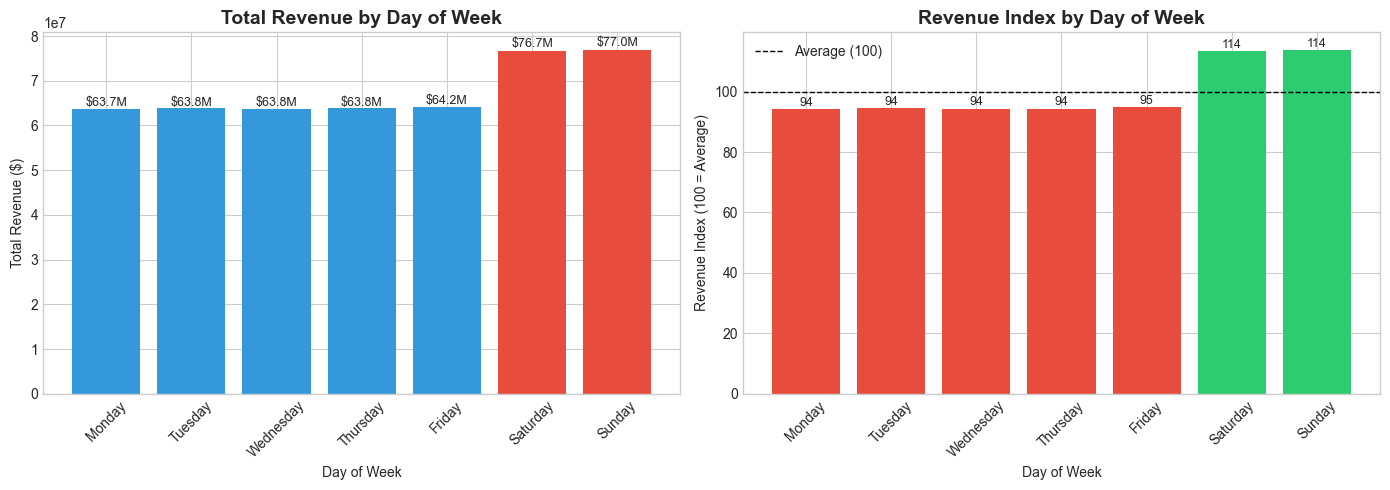


--- WEEKDAY VS WEEKEND ---
Weekday Total Revenue: $319,265,307.67 (Avg per transaction: $406.93)
Weekend Total Revenue: $153,681,145.16 (Avg per transaction: $487.21)
Weekend/Weekday Ratio: 119.73%

--- WEEKLY INSIGHTS ---
Best Day: Sunday (Index: 113.9)
Worst Day: Monday (Index: 94.2)

[OK] agg_weekly_trend table created!


In [15]:
# =============================================================================
# WEEKLY PATTERN ANALYSIS
# =============================================================================
# Analisis pola mingguan berdasarkan hari dalam seminggu
# Mengidentifikasi hari-hari dengan penjualan tinggi/rendah
# =============================================================================

# Agregasi per weekday
agg_weekly_trend = df.groupby(['weekday', 'weekday_name']).agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    avg_revenue=('net_sales', 'mean'),
    avg_units=('units_sold', 'mean'),
    transaction_count=('net_sales', 'count')
).round(2).reset_index()

# Sort by weekday (0=Monday, 6=Sunday)
agg_weekly_trend = agg_weekly_trend.sort_values('weekday')

# Calculate revenue index
avg_daily_revenue = agg_weekly_trend['total_revenue'].mean()
agg_weekly_trend['revenue_index'] = (agg_weekly_trend['total_revenue'] / avg_daily_revenue * 100).round(1)

# Display results
print("=" * 60)
print("WEEKLY PATTERN ANALYSIS")
print("=" * 60)
display(agg_weekly_trend)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Total Revenue by Weekday
colors_week = ['#3498db'] * 5 + ['#e74c3c'] * 2  # Weekdays blue, weekend red
bars1 = axes[0].bar(weekday_order, agg_weekly_trend['total_revenue'], color=colors_week)
axes[0].set_ylabel('Total Revenue ($)')
axes[0].set_xlabel('Day of Week')
axes[0].set_title('Total Revenue by Day of Week', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars1, agg_weekly_trend['total_revenue']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                 f'${val/1e6:.1f}M', ha='center', fontsize=9)

# Revenue Index by Weekday
colors_idx = ['#2ecc71' if x > 100 else '#e74c3c' for x in agg_weekly_trend['revenue_index']]
bars2 = axes[1].bar(weekday_order, agg_weekly_trend['revenue_index'], color=colors_idx)
axes[1].axhline(y=100, color='black', linestyle='--', linewidth=1, label='Average (100)')
axes[1].set_ylabel('Revenue Index (100 = Average)')
axes[1].set_xlabel('Day of Week')
axes[1].set_title('Revenue Index by Day of Week', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Add value labels
for bar, val in zip(bars2, agg_weekly_trend['revenue_index']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Weekend vs Weekday comparison
df_weekend = df[df['is_weekend'] == 1]
df_weekday = df[df['is_weekend'] == 0]

weekend_revenue = df_weekend['net_sales'].sum()
weekday_revenue = df_weekday['net_sales'].sum()
weekend_avg = df_weekend['net_sales'].mean()
weekday_avg = df_weekday['net_sales'].mean()

print("\n--- WEEKDAY VS WEEKEND ---")
print(f"Weekday Total Revenue: ${weekday_revenue:,.2f} (Avg per transaction: ${weekday_avg:.2f})")
print(f"Weekend Total Revenue: ${weekend_revenue:,.2f} (Avg per transaction: ${weekend_avg:.2f})")
print(f"Weekend/Weekday Ratio: {weekend_avg/weekday_avg:.2%}")

# Insights
print("\n--- WEEKLY INSIGHTS ---")
best_day = agg_weekly_trend.loc[agg_weekly_trend['revenue_index'].idxmax(), 'weekday_name']
worst_day = agg_weekly_trend.loc[agg_weekly_trend['revenue_index'].idxmin(), 'weekday_name']
print(f"Best Day: {best_day} (Index: {agg_weekly_trend['revenue_index'].max():.1f})")
print(f"Worst Day: {worst_day} (Index: {agg_weekly_trend['revenue_index'].min():.1f})")

print("\n[OK] agg_weekly_trend table created!")

### DIMENSION TABLE: dim_sku
&emsp; Dimension table dim_sku adalah tabel referensi (lookup table) yang berisi informasi unik terkait SKU (Stock Keeping Unit). Tabel ini menyimpan atribut deskriptif produk seperti nama SKU, kategori, subkategori, dan brand, sehingga dapat digunakan sebagai pengaya (enrichment) ketika melakukan analisis lebih lanjut atau ketika menghubungkan data ke fact table di Looker.

Pada analisis ini, dimension table tidak hanya berfungsi sebagai daftar produk, tetapi juga memperkaya setiap SKU dengan hasil klasifikasi performa, yaitu:
- ABC Classification berdasarkan kontribusi revenue.
- XYZ Classification berdasarkan kestabilan permintaan (Coefficient of Variation).
- Kombinasi ABC–XYZ sebagai segmen produk yang lebih granular.

Langkah-langkah pembentukannya mencakup:
- Membuat daftar SKU unik beserta atribut deskriptifnya.
- Menggabungkan nilai ABC class dari analisis sebelumnya untuk menunjukkan tingkat kontribusi SKU terhadap revenue total.
- Menggabungkan nilai XYZ class untuk menggambarkan kestabilan permintaan setiap produk.
- Membuat kolom gabungan ABC–XYZ yang mempermudah segmentasi performa SKU.
- Mengurutkan SKU berdasarkan total revenue tertinggi, sehingga produk utama dapat segera terlihat.
- Menyajikan ringkasan jumlah SKU, kategori, subkategori, dan brand, serta distribusi SKU dalam matriks ABC–XYZ.

&emsp; Dengan adanya tabel dim_sku ini, proses analisis di Looker atau BI Tools lainnya menjadi lebih efisien dan terstruktur, karena setiap SKU sudah memiliki klasifikasi performa yang dapat digunakan untuk segmentation, filtering, maupun advanced analytics seperti forecasting dan inventory planning.

In [16]:
# =============================================================================
# DIMENSION TABLE: dim_sku
# =============================================================================
# Lookup table untuk SKU dengan informasi produk
# Digunakan untuk join dengan fact tables di Looker
# =============================================================================

# Create dim_sku with unique SKU attributes
dim_sku = df[['sku_id', 'sku_name', 'category', 'subcategory', 'brand']].drop_duplicates()

# Add ABC class from previous analysis
dim_sku = dim_sku.merge(
    abc_df[['sku_id', 'abc_class', 'total_revenue', 'revenue_pct']], 
    on='sku_id', 
    how='left'
)

# Add XYZ class from previous analysis
dim_sku = dim_sku.merge(
    xyz_df[['sku_id', 'xyz_class', 'cv', 'mean_units']], 
    on='sku_id', 
    how='left'
)

# Create combined ABC-XYZ class
dim_sku['abc_xyz_class'] = dim_sku['abc_class'] + dim_sku['xyz_class']

# Sort by total_revenue descending
dim_sku = dim_sku.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Display results
print("=" * 60)
print("DIMENSION TABLE: dim_sku")
print("=" * 60)
print(f"Total SKUs: {len(dim_sku)}")
print(f"Categories: {dim_sku['category'].nunique()}")
print(f"Subcategories: {dim_sku['subcategory'].nunique()}")
print(f"Brands: {dim_sku['brand'].nunique()}")
print()

# Show column info
print("Columns:")
for col in dim_sku.columns:
    print(f"  - {col}: {dim_sku[col].dtype}")
print()

# Display sample
display(dim_sku.head(10))

# ABC-XYZ Matrix summary
print("\n--- ABC-XYZ Matrix Distribution ---")
abc_xyz_matrix = dim_sku.groupby('abc_xyz_class').size().reset_index(name='sku_count')
abc_xyz_matrix['pct'] = (abc_xyz_matrix['sku_count'] / len(dim_sku) * 100).round(2)
display(abc_xyz_matrix.sort_values('sku_count', ascending=False))

print("\n[OK] dim_sku lookup table created!")

DIMENSION TABLE: dim_sku
Total SKUs: 102
Categories: 5
Subcategories: 17
Brands: 6

Columns:
  - sku_id: object
  - sku_name: object
  - category: object
  - subcategory: object
  - brand: object
  - abc_class: object
  - total_revenue: float64
  - revenue_pct: float64
  - xyz_class: object
  - cv: float64
  - mean_units: float64
  - abc_xyz_class: object



,sku_id,sku_name,category,subcategory,brand,abc_class,total_revenue,revenue_pct,xyz_class,cv,mean_units,abc_xyz_class
0,SKU0018,BrandF Water,Beverages,Water,BrandF,A,"17,032,424.64",3.60,X,0.21,"32,584.22",AX
1,SKU0027,BrandC Chips,Snacks,Chips,BrandC,A,"16,000,295.02",3.38,X,0.10,"33,358.25",AX
2,SKU0026,BrandB Chips,Snacks,Chips,BrandB,A,"13,025,419.73",2.75,X,0.11,"24,833.03",AX
3,SKU0099,BrandC Toothpaste,Personal Care,Toothpaste,BrandC,A,"12,968,809.43",2.74,X,0.08,"34,510.81",AX
4,SKU0092,BrandB Soap,Personal Care,Soap,BrandB,A,"12,496,995.90",2.64,X,0.04,"24,884.50",AX
5,SKU0100,BrandD Toothpaste,Personal Care,Toothpaste,BrandD,A,"12,351,150.68",2.61,X,0.03,"25,565.39",AX
6,SKU0064,BrandD Cheese,Dairy,Cheese,BrandD,A,"12,326,994.00",2.61,X,0.03,"27,503.33",AX
7,SKU0061,BrandA Cheese,Dairy,Cheese,BrandA,A,"11,967,260.40",2.53,X,0.03,"27,026.33",AX
8,SKU0028,BrandD Chips,Snacks,Chips,BrandD,A,"11,749,108.59",2.48,X,0.12,"34,830.75",AX
9,SKU0097,BrandA Toothpaste,Personal Care,Toothpaste,BrandA,A,"11,594,508.71",2.45,X,0.03,"23,664.19",AX



--- ABC-XYZ Matrix Distribution ---


,abc_xyz_class,sku_count,pct
0,AX,49,48.04
1,BX,29,28.43
2,CX,24,23.53



[OK] dim_sku lookup table created!


### DIMENSION TABLE: dim_store
&emsp; dim_store adalah dimension table yang berisi informasi deskriptif mengenai setiap store. Tabel ini berfungsi sebagai lookup table untuk menambah konteks lokasi dan karakteristik store ketika melakukan analisis performa penjualan. Pada analisis ini, dim_store tidak hanya menyimpan atribut lokasi, tetapi juga sudah diperkaya dengan berbagai metrik performa store sehingga dapat langsung digunakan untuk analisis lanjutan maupun visualisasi di Looker Studio.

Pembangunan tabel dim_store mencakup beberapa proses penting:

1. Membuat daftar store unik yang berisi atribut utama seperti:
    - store_id
    - negara (country)
    - kota (city)
    - jenis channel (channel)
    - koordinat geografis (latitude & longitude) untuk mendukung visualisasi peta di Looker.

2. Menambahkan metrik performa per store, antara lain:
    - total_revenue: total penjualan bersih,
    - total_units: total unit terjual,
    - transaction_count: jumlah transaksi,
    - avg_basket_size: rata-rata nilai transaksi,
    - unique_skus: jumlah SKU unik yang terjual di store tersebut.

3. Melakukan merge antara informasi lokasi dan performa store berdasarkan store_id.

4. Mengurutkan store berdasarkan total revenue, sehingga membantu identifikasi store paling berkontribusi terhadap bisnis.

5. Menyediakan ringkasan dimensi, seperti total store, jumlah country, city, dan channel yang ada dalam dataset.

6. Menganalisis distribusi store berdasarkan channel, termasuk jumlah store, total revenue per channel, dan persentase distribusinya.

&emsp; Dengan dim_store ini, proses analisis menjadi lebih efisien karena setiap store sudah memiliki informasi lokasi dan performa yang lengkap. Tabel ini sangat berguna untuk membuat dashboard berbasis peta, membandingkan performa antar-store, serta melakukan segmentasi berdasarkan channel atau wilayah.

In [17]:
# =============================================================================
# DIMENSION TABLE: dim_store
# =============================================================================
# Lookup table untuk Store dengan informasi lokasi
# Termasuk koordinat untuk visualisasi peta di Looker
# =============================================================================

# Create dim_store with unique store attributes
dim_store = df[['store_id', 'country', 'city', 'channel', 'latitude', 'longitude']].drop_duplicates()

# Add store performance metrics
store_metrics = df.groupby('store_id').agg(
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    transaction_count=('net_sales', 'count'),
    avg_basket_size=('net_sales', 'mean'),
    unique_skus=('sku_id', 'nunique')
).round(2).reset_index()

dim_store = dim_store.merge(store_metrics, on='store_id', how='left')

# Sort by total_revenue descending
dim_store = dim_store.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Display results
print("=" * 60)
print("DIMENSION TABLE: dim_store")
print("=" * 60)
print(f"Total Stores: {len(dim_store)}")
print(f"Countries: {dim_store['country'].nunique()}")
print(f"Cities: {dim_store['city'].nunique()}")
print(f"Channels: {dim_store['channel'].nunique()}")
print()

# Show column info
print("Columns:")
for col in dim_store.columns:
    print(f"  - {col}: {dim_store[col].dtype}")
print()

# Display sample
display(dim_store.head(10))

# Channel distribution
print("\n--- Store Distribution by Channel ---")
channel_dist = dim_store.groupby('channel').agg(
    store_count=('store_id', 'count'),
    total_revenue=('total_revenue', 'sum')
).round(2)
channel_dist['pct_stores'] = (channel_dist['store_count'] / len(dim_store) * 100).round(2)
display(channel_dist)

print("\n[OK] dim_store lookup table created!")

DIMENSION TABLE: dim_store
Total Stores: 13
Countries: 7
Cities: 9
Channels: 4

Columns:
  - store_id: object
  - country: object
  - city: object
  - channel: object
  - latitude: float64
  - longitude: float64
  - total_revenue: float64
  - total_units: int64
  - transaction_count: int64
  - avg_basket_size: float64
  - unique_skus: int64



,store_id,country,city,channel,latitude,longitude,total_revenue,total_units,transaction_count,avg_basket_size,unique_skus
0,STORE0004,Germany,Berlin,Hypermarket,52.50,13.42,"46,585,753.18",6057129,87600,531.80,80
1,STORE0008,Austria,Vienna,Hypermarket,48.20,16.36,"43,020,025.97",5742174,87600,491.10,80
2,STORE0006,France,Paris,Hypermarket,48.88,2.36,"42,601,612.57",6014974,87600,486.32,80
3,STORE0005,Poland,Warsaw,Hypermarket,52.25,21.00,"42,385,262.52",5860180,87600,483.85,80
4,STORE0011,Italy,Rome,Hypermarket,41.91,12.51,"42,205,660.63",5985522,87600,481.80,80
5,STORE0001,Germany,Berlin,Hypermarket,52.53,13.39,"41,939,805.83",5681442,87600,478.76,80
6,STORE0012,Spain,Madrid,E-commerce,40.42,-3.67,"38,965,417.77",5243338,87600,444.81,80
7,STORE0009,Spain,Barcelona,E-commerce,41.37,2.16,"37,766,116.12",5297695,87600,431.12,80
8,STORE0010,Italy,Milan,E-commerce,45.46,9.20,"36,002,989.23",5106947,87600,410.99,80
9,STORE0002,Italy,Rome,Supermarket,41.94,12.51,"30,231,862.00",4249838,87600,345.11,80



--- Store Distribution by Channel ---


,store_count,total_revenue,pct_stores
channel,,,
Convenience,1,"12,516,149.60",7.69
E-commerce,3,"112,734,523.12",23.08
Hypermarket,6,"258,738,120.70",46.15
Supermarket,3,"88,957,659.41",23.08



[OK] dim_store lookup table created!


### DIMENSION TABLE: dim_supplier
&emsp; dim_supplier adalah dimension table yang berisi informasi lengkap mengenai setiap supplier yang menyuplai produk dalam dataset. Tabel ini berfungsi sebagai lookup table untuk analisis supply chain, terutama ketika melakukan evaluasi performa supplier di Google Looker atau tools BI lainnya. Dengan menggabungkan atribut performa dan biaya, tabel ini memberikan gambaran menyeluruh mengenai efisiensi, kontribusi, dan stabilitas masing-masing supplier.

Dalam proses pembentukannya, beberapa langkah analitis dilakukan:

1. Mengumpulkan metrik-metrik utama per supplier, seperti:
    - avg_lead_time, min_lead_time, dan max_lead_time untuk mengukur kecepatan dan konsistensi pengiriman.
    - avg_purchase_cost dan total_purchase_cost untuk melihat biaya pembelian produk dari supplier.
    - total_revenue dan total_units untuk mengetahui kontribusi supplier terhadap penjualan.
    - unique_skus untuk melihat seberapa banyak variasi produk yang mereka suplai.
    - transaction_count untuk jumlah transaksi terkait supplier tersebut.

2. Menghitung metrik turunan (derived metrics) yang dapat membantu pengambilan keputusan:
    - avg_margin (%): menunjukkan profitabilitas rata-rata supplier (selisih revenue dan purchase cost).
    - revenue_per_sku: mengukur efektivitas setiap SKU yang disuplai terhadap pendapatan.
    - Mengurutkan supplier berdasarkan total revenue, sehingga supplier dengan pengaruh terbesar terhadap penjualan muncul di urutan teratas.
    - Menyediakan ringkasan statistik, seperti jumlah total supplier dan rata-rata lead time secara keseluruhan.
    - Menampilkan sampel data dan tipe kolom, memastikan struktur tabel mudah digunakan pada tahap analisis berikutnya.

3. Membuat visualisasi performa supplier, termasuk:
    - Top 10 suppliers by revenue (horizontal bar chart),
    - Lead Time vs Revenue dengan ukuran titik mewakili jumlah SKU.

&emsp; Dengan adanya dim_supplier ini, analis dapat dengan mudah mengevaluasi performa supplier, mengidentifikasi supplier berisiko tinggi (misalnya lead time panjang atau margin rendah), serta melakukan perencanaan supply chain yang lebih efektif.

DIMENSION TABLE: dim_supplier
Total Suppliers: 60
Avg Lead Time (overall): 6.5 days
Avg Purchase Cost (overall): $4.63

Columns:
  - supplier_id: object
  - avg_lead_time: float64
  - min_lead_time: int64
  - max_lead_time: int64
  - avg_purchase_cost: float64
  - total_purchase_cost: float64
  - total_revenue: float64
  - total_units: int64
  - unique_skus: int64
  - transaction_count: int64
  - avg_margin: float64
  - revenue_per_sku: float64



,supplier_id,avg_lead_time,min_lead_time,max_lead_time,avg_purchase_cost,total_purchase_cost,total_revenue,total_units,unique_skus,transaction_count,avg_margin,revenue_per_sku
0,S028,6.49,1,14,4.64,"85,699.25","8,098,911.98",1110301,102,18469,98.94,"79,401.10"
1,S041,6.50,1,14,4.63,"85,810.46","8,031,550.47",1105374,102,18533,98.93,"78,740.69"
2,S046,6.51,1,14,4.67,"84,660.40","8,001,574.83",1088293,102,18143,98.94,"78,446.81"
3,S055,6.45,1,14,4.64,"85,373.33","7,997,185.71",1092639,102,18380,98.93,"78,403.78"
4,S044,6.50,1,14,4.62,"85,268.81","7,985,912.37",1103845,102,18465,98.93,"78,293.26"
5,S037,6.51,1,14,4.65,"86,441.89","7,985,278.61",1096884,102,18579,98.92,"78,287.05"
6,S045,6.51,1,14,4.65,"85,771.54","7,979,496.77",1089668,102,18464,98.93,"78,230.36"
7,S040,6.50,1,15,4.62,"85,528.50","7,974,363.24",1098705,102,18529,98.93,"78,180.03"
8,S012,6.49,1,14,4.61,"85,058.90","7,973,610.44",1104391,102,18438,98.93,"78,172.65"
9,S019,6.52,1,15,4.60,"85,174.07","7,967,360.89",1104187,102,18502,98.93,"78,111.38"


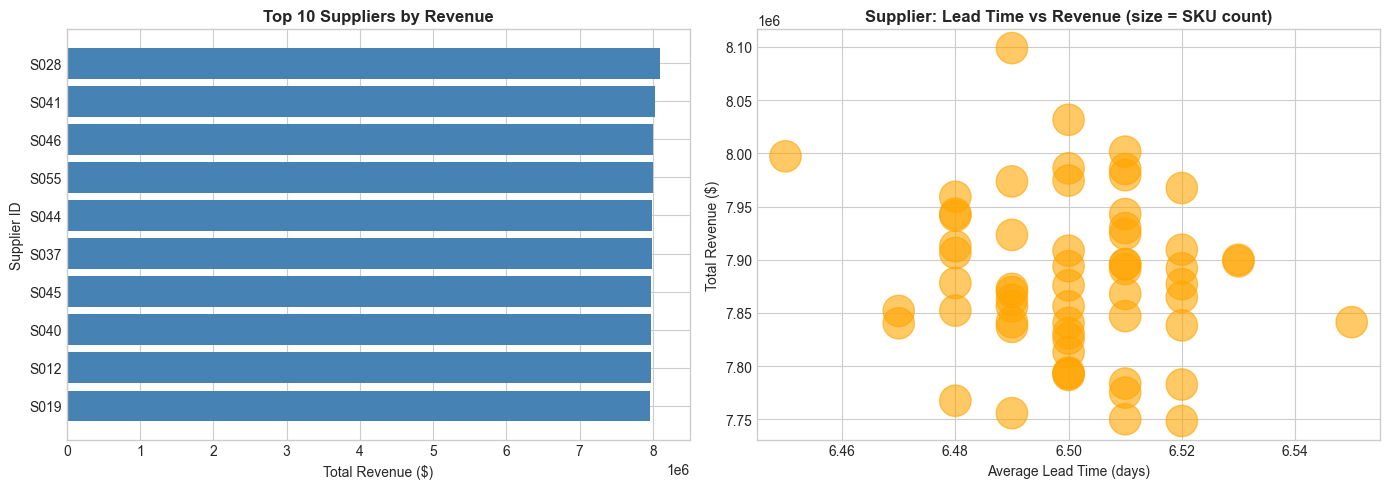


[OK] dim_supplier lookup table created!


In [18]:
# =============================================================================
# DIMENSION TABLE: dim_supplier
# =============================================================================
# Lookup table untuk Supplier dengan metrik kinerja
# Berguna untuk analisis supply chain di Looker
# =============================================================================

# Create dim_supplier with aggregated metrics
dim_supplier = df.groupby('supplier_id').agg(
    avg_lead_time=('lead_time_days', 'mean'),
    min_lead_time=('lead_time_days', 'min'),
    max_lead_time=('lead_time_days', 'max'),
    avg_purchase_cost=('purchase_cost', 'mean'),
    total_purchase_cost=('purchase_cost', 'sum'),
    total_revenue=('net_sales', 'sum'),
    total_units=('units_sold', 'sum'),
    unique_skus=('sku_id', 'nunique'),
    transaction_count=('net_sales', 'count')
).round(2).reset_index()

# Calculate derived metrics
dim_supplier['avg_margin'] = ((dim_supplier['total_revenue'] - dim_supplier['total_purchase_cost']) / 
                               dim_supplier['total_revenue'] * 100).round(2)
dim_supplier['revenue_per_sku'] = (dim_supplier['total_revenue'] / dim_supplier['unique_skus']).round(2)

# Sort by total_revenue descending
dim_supplier = dim_supplier.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Display results
print("=" * 60)
print("DIMENSION TABLE: dim_supplier")
print("=" * 60)
print(f"Total Suppliers: {len(dim_supplier)}")
print(f"Avg Lead Time (overall): {dim_supplier['avg_lead_time'].mean():.1f} days")
print(f"Avg Purchase Cost (overall): ${dim_supplier['avg_purchase_cost'].mean():.2f}")
print()

# Show column info
print("Columns:")
for col in dim_supplier.columns:
    print(f"  - {col}: {dim_supplier[col].dtype}")
print()

# Display sample
display(dim_supplier.head(10))

# Supplier performance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 10 suppliers by revenue
top_10_suppliers = dim_supplier.head(10)
axes[0].barh(top_10_suppliers['supplier_id'], top_10_suppliers['total_revenue'], color='steelblue')
axes[0].set_xlabel('Total Revenue ($)')
axes[0].set_ylabel('Supplier ID')
axes[0].set_title('Top 10 Suppliers by Revenue', fontweight='bold')
axes[0].invert_yaxis()

# Lead time distribution
axes[1].scatter(dim_supplier['avg_lead_time'], dim_supplier['total_revenue'], 
                s=dim_supplier['unique_skus']*5, alpha=0.6, c='orange')
axes[1].set_xlabel('Average Lead Time (days)')
axes[1].set_ylabel('Total Revenue ($)')
axes[1].set_title('Supplier: Lead Time vs Revenue (size = SKU count)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n[OK] dim_supplier lookup table created!")

In [19]:
# =============================================================================
# EXPORT TO CSV
# =============================================================================
# Export semua tabel agregat dan lookup ke format CSV
# Siap untuk diimport ke Google Looker atau tools visualisasi lainnya
# =============================================================================

import os

# Create output directory
output_dir = 'output_looker'
os.makedirs(output_dir, exist_ok=True)

# Define all expected tables with their variable names
table_names = [
    # Aggregated Tables (Fact Tables)
    'agg_revenue_by_country',
    'agg_monthly_trend',
    'agg_weekly_trend',
    'top_20_sku',
    'sku_revenue',
    'abc_summary',
    'xyz_summary',
    'abc_by_region',
    'promo_analysis',
    'promo_lift_by_cat',
    'correlation_matrix',
    # Dimension Tables (Lookup Tables)
    'dim_sku',
    'dim_store',
    'dim_supplier',
    # Classification Tables
    'abc_df',
    'xyz_df',
]

# Check which tables exist and build export dictionary
tables_to_export = {}
missing_tables = []

for table_name in table_names:
    if table_name in dir():
        tables_to_export[table_name] = eval(table_name)
    else:
        missing_tables.append(table_name)

if 'promo_lift_by_cat' in tables_to_export:
    promo_lift_by_cat_fixed = tables_to_export['promo_lift_by_cat'].reset_index()
    promo_lift_by_cat_fixed = promo_lift_by_cat_fixed.rename(columns={'index': 'category'})
    tables_to_export['promo_lift_by_cat'] = promo_lift_by_cat_fixed

# Report status
print("=" * 60)
print("EXPORTING TABLES TO CSV")
print("=" * 60)
print(f"Output Directory: {os.path.abspath(output_dir)}")
print(f"Tables found: {len(tables_to_export)}")
print(f"Tables missing: {len(missing_tables)}")

if missing_tables:
    print(f"\n[WARNING] Missing tables (run previous cells first):")
    for t in missing_tables:
        print(f"  - {t}")
print()

# Export each available table
export_summary = []
for table_name, table_df in tables_to_export.items():
    file_path = os.path.join(output_dir, f'{table_name}.csv')
    
    # Handle Period columns (convert to string)
    df_export = table_df.copy()
    for col in df_export.columns:
        if str(df_export[col].dtype).startswith('period'):
            df_export[col] = df_export[col].astype(str)
    
    # Export to CSV
    df_export.to_csv(file_path, index=False, encoding='utf-8')
    
    # Get file size
    file_size = os.path.getsize(file_path)
    file_size_kb = file_size / 1024
    
    export_summary.append({
        'table_name': table_name,
        'rows': len(table_df),
        'columns': len(table_df.columns),
        'file_size_kb': round(file_size_kb, 2)
    })
    
    print(f"[OK] {table_name}.csv - {len(table_df):,} rows, {len(table_df.columns)} cols, {file_size_kb:.1f} KB")

# Create export summary table
if export_summary:
    export_summary_df = pd.DataFrame(export_summary)
    export_summary_df.to_csv(os.path.join(output_dir, '_export_summary.csv'), index=False)
    
    print()
    print("=" * 60)
    print("EXPORT SUMMARY")
    print("=" * 60)
    display(export_summary_df)
    
    total_size = export_summary_df['file_size_kb'].sum()
    total_rows = export_summary_df['rows'].sum()
    print(f"\nTotal Files: {len(export_summary_df)}")
    print(f"Total Rows: {total_rows:,}")
    print(f"Total Size: {total_size:.1f} KB ({total_size/1024:.2f} MB)")
    print(f"\nAll files exported to: {os.path.abspath(output_dir)}")
    print("\n[OK] CSV export completed successfully!")
else:
    print("[ERROR] No tables available to export. Please run all previous cells first.")

EXPORTING TABLES TO CSV
Output Directory: c:\pdvd-project\uas\preprocessing-data-fmcg\output_looker
Tables found: 16
Tables missing: 0

[OK] agg_revenue_by_country.csv - 7 rows, 6 cols, 0.4 KB
[OK] agg_monthly_trend.csv - 36 rows, 8 cols, 1.9 KB
[OK] agg_weekly_trend.csv - 7 rows, 8 cols, 0.5 KB
[OK] top_20_sku.csv - 20 rows, 10 cols, 1.7 KB
[OK] sku_revenue.csv - 102 rows, 8 cols, 6.9 KB
[OK] abc_summary.csv - 3 rows, 5 cols, 0.2 KB
[OK] xyz_summary.csv - 1 rows, 4 cols, 0.1 KB
[OK] abc_by_region.csv - 21 rows, 7 cols, 1.0 KB
[OK] promo_analysis.csv - 2 rows, 6 cols, 0.2 KB
[OK] promo_lift_by_cat.csv - 5 rows, 7 cols, 0.4 KB
[OK] correlation_matrix.csv - 7 rows, 7 cols, 0.4 KB
[OK] dim_sku.csv - 102 rows, 12 cols, 9.7 KB
[OK] dim_store.csv - 13 rows, 11 cols, 1.3 KB
[OK] dim_supplier.csv - 60 rows, 12 cols, 4.5 KB
[OK] abc_df.csv - 102 rows, 11 cols, 8.6 KB
[OK] xyz_df.csv - 102 rows, 9 cols, 8.8 KB

EXPORT SUMMARY


,table_name,rows,columns,file_size_kb
0,agg_revenue_by_country,7,6,0.41
1,agg_monthly_trend,36,8,1.93
2,agg_weekly_trend,7,8,0.49
3,top_20_sku,20,10,1.66
4,sku_revenue,102,8,6.94
5,abc_summary,3,5,0.17
6,xyz_summary,1,4,0.07
7,abc_by_region,21,7,1.00
8,promo_analysis,2,6,0.20
9,promo_lift_by_cat,5,7,0.40



Total Files: 16
Total Rows: 590
Total Size: 46.5 KB (0.05 MB)

All files exported to: c:\pdvd-project\uas\preprocessing-data-fmcg\output_looker

[OK] CSV export completed successfully!


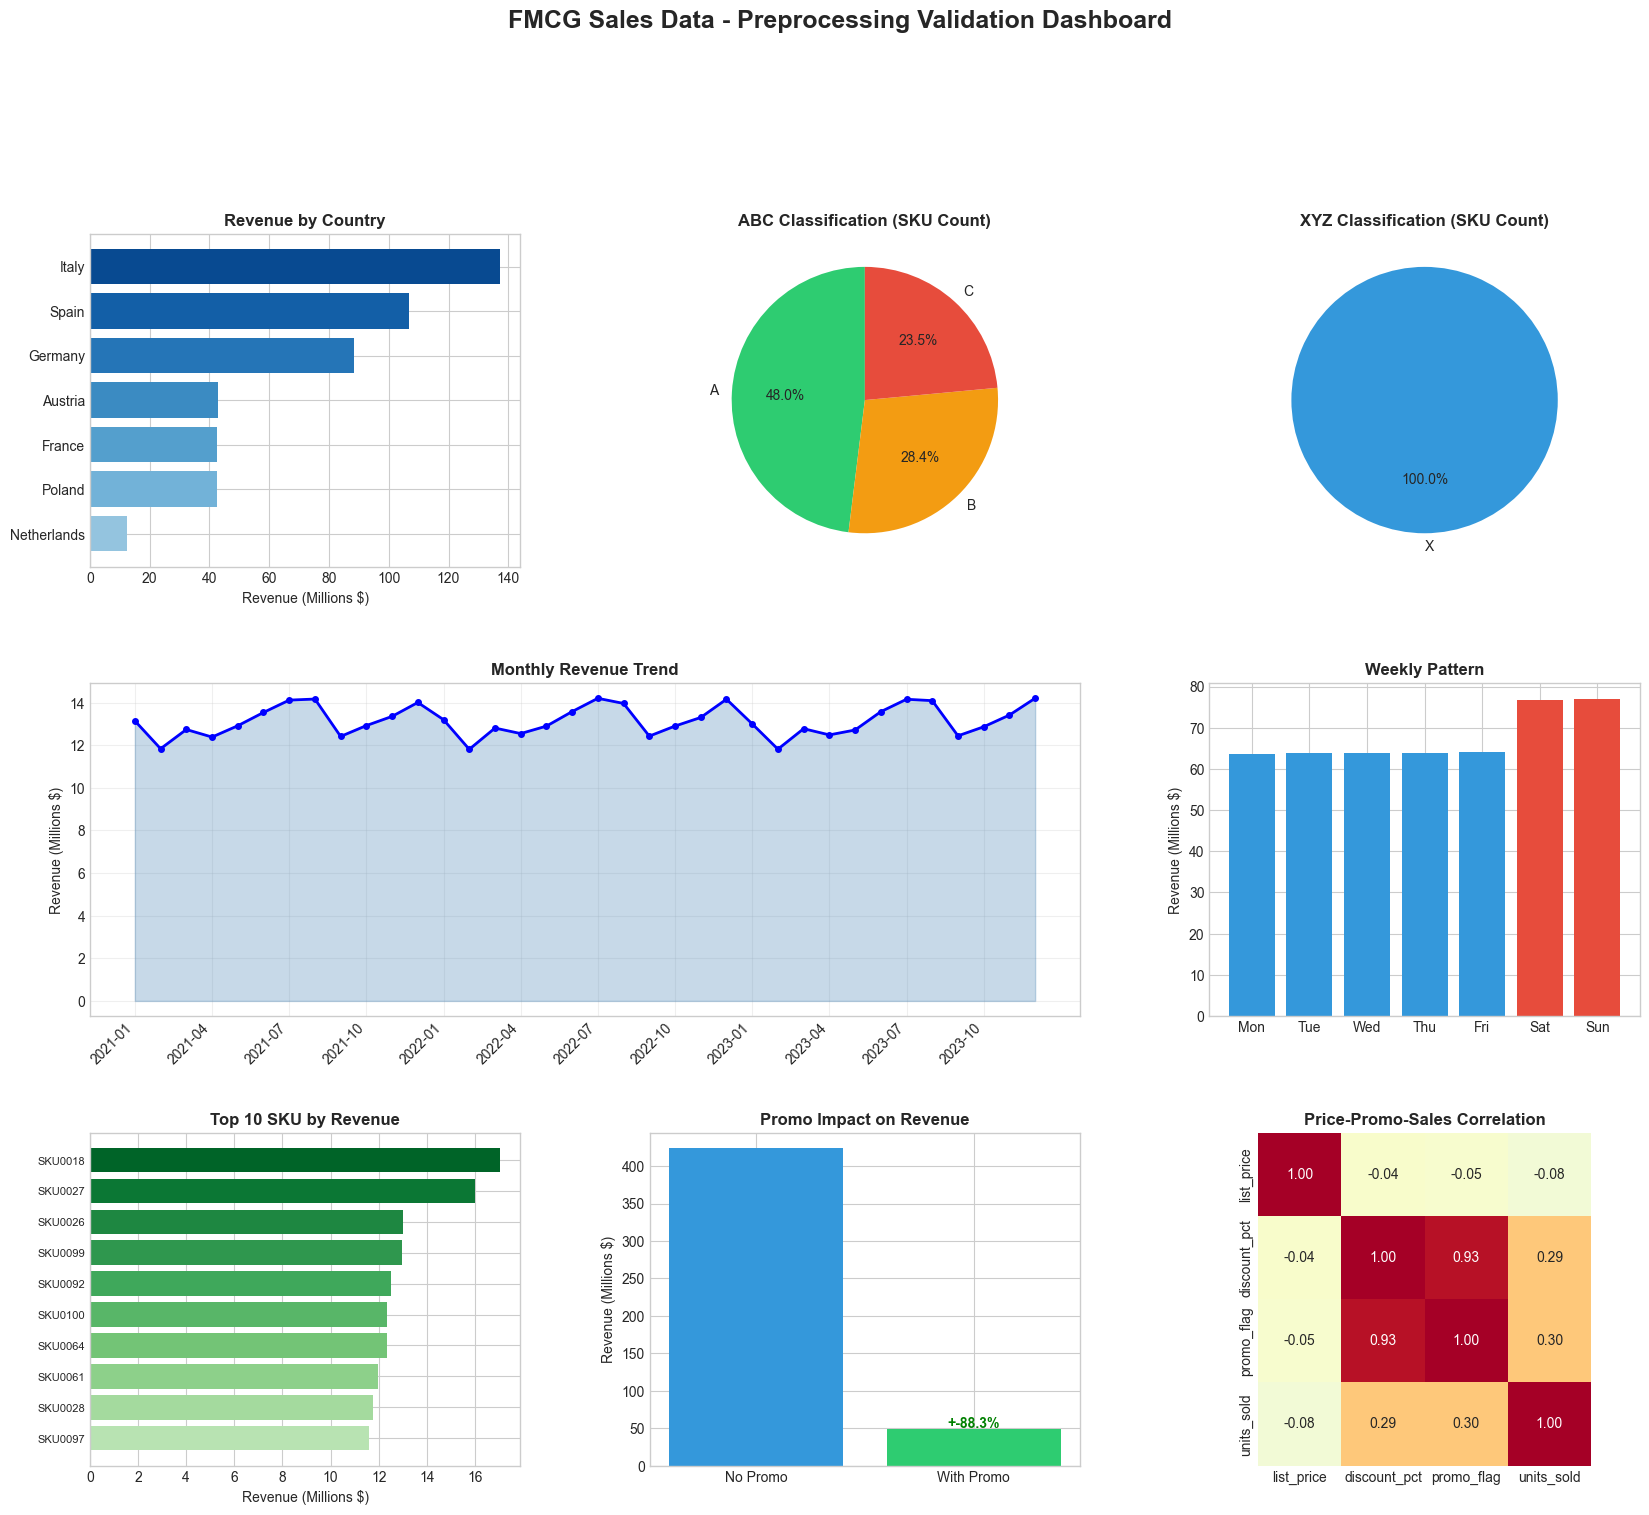


PREPROCESSING SUMMARY
Dataset Size: 1,100,000 rows x 36 columns
Date Range: 2021-01-01 to 2023-12-31
Total Revenue: $472,946,452.83
Total Units Sold: 65,115,982
Unique SKUs: 102
Unique Stores: 13
Countries: 7
Suppliers: 60

Tables Created:
  - Aggregated: agg_revenue_by_country, agg_monthly_trend, agg_weekly_trend
  - SKU Analysis: sku_revenue, top_20_sku, abc_df, xyz_df
  - Dimensions: dim_sku, dim_store, dim_supplier
  - Analysis: correlation_matrix, promo_analysis, promo_lift_by_cat

Dashboard saved to: output_looker/validation_dashboard.png

[OK] All preprocessing completed successfully!


In [20]:
# =============================================================================
# SUMMARY VISUALIZATIONS - VALIDATION DASHBOARD
# =============================================================================
# Multiple charts untuk memvalidasi hasil transformasi data
# Digunakan sebagai preview sebelum data dipindahkan ke Looker
# =============================================================================

# Create a comprehensive dashboard
fig = plt.figure(figsize=(20, 16))
fig.suptitle('FMCG Sales Data - Preprocessing Validation Dashboard', 
             fontsize=18, fontweight='bold', y=1.02)

# Define grid
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ===================
# Chart 1: Revenue by Country (Top-Left)
# ===================
ax1 = fig.add_subplot(gs[0, 0])
colors1 = plt.cm.Blues(np.linspace(0.4, 0.9, len(agg_revenue_by_country)))
ax1.barh(agg_revenue_by_country['country'], 
         agg_revenue_by_country['total_revenue']/1e6, 
         color=colors1[::-1])
ax1.set_xlabel('Revenue (Millions $)')
ax1.set_title('Revenue by Country', fontweight='bold')
ax1.invert_yaxis()

# ===================
# Chart 2: ABC Distribution Pie (Top-Center)
# ===================
ax2 = fig.add_subplot(gs[0, 1])
abc_colors = {'A': '#2ecc71', 'B': '#f39c12', 'C': '#e74c3c'}
ax2.pie(abc_summary['sku_count'], 
        labels=abc_summary.index, 
        autopct='%1.1f%%',
        colors=[abc_colors.get(x, '#95a5a6') for x in abc_summary.index], 
        startangle=90)
ax2.set_title('ABC Classification (SKU Count)', fontweight='bold')

# ===================
# Chart 3: XYZ Distribution Pie (Top-Right)
# ===================
ax3 = fig.add_subplot(gs[0, 2])
xyz_colors = {'X': '#3498db', 'Y': '#9b59b6', 'Z': '#e74c3c'}
ax3.pie(xyz_summary['sku_count'], 
        labels=xyz_summary.index, 
        autopct='%1.1f%%',
        colors=[xyz_colors.get(x, '#95a5a6') for x in xyz_summary.index], 
        startangle=90)
ax3.set_title('XYZ Classification (SKU Count)', fontweight='bold')

# ===================
# Chart 4: Monthly Revenue Trend (Middle-Left + Center)
# ===================
ax4 = fig.add_subplot(gs[1, :2])
ax4.fill_between(range(len(agg_monthly_trend)), 
                 agg_monthly_trend['total_revenue']/1e6, 
                 alpha=0.3, color='steelblue')
ax4.plot(range(len(agg_monthly_trend)), 
         agg_monthly_trend['total_revenue']/1e6, 
         'b-', linewidth=2, marker='o', markersize=4)
ax4.set_xticks(range(0, len(agg_monthly_trend), 3))
ax4.set_xticklabels(agg_monthly_trend['year_month_label'].iloc[::3], rotation=45, ha='right')
ax4.set_ylabel('Revenue (Millions $)')
ax4.set_title('Monthly Revenue Trend', fontweight='bold')
ax4.grid(True, alpha=0.3)

# ===================
# Chart 5: Weekly Pattern (Middle-Right)
# ===================
ax5 = fig.add_subplot(gs[1, 2])
week_colors = ['#3498db'] * 5 + ['#e74c3c'] * 2
ax5.bar(range(7), agg_weekly_trend['total_revenue']/1e6, color=week_colors)
ax5.set_xticks(range(7))
ax5.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax5.set_ylabel('Revenue (Millions $)')
ax5.set_title('Weekly Pattern', fontweight='bold')

# ===================
# Chart 6: Top 10 SKU (Bottom-Left)
# ===================
ax6 = fig.add_subplot(gs[2, 0])
top_10 = top_20_sku.head(10)
colors6 = plt.cm.Greens(np.linspace(0.3, 0.9, 10))
ax6.barh(range(10), top_10['total_revenue']/1e6, color=colors6[::-1])
ax6.set_yticks(range(10))
ax6.set_yticklabels([f"{row['sku_id'][:10]}" for _, row in top_10.iterrows()], fontsize=8)
ax6.set_xlabel('Revenue (Millions $)')
ax6.set_title('Top 10 SKU by Revenue', fontweight='bold')
ax6.invert_yaxis()

# ===================
# Chart 7: Promo Impact (Bottom-Center)
# ===================
ax7 = fig.add_subplot(gs[2, 1])
promo_data = promo_analysis['total_revenue']/1e6
ax7.bar(['No Promo', 'With Promo'], promo_data, color=['#3498db', '#2ecc71'])
ax7.set_ylabel('Revenue (Millions $)')
ax7.set_title('Promo Impact on Revenue', fontweight='bold')
lift = (promo_data.iloc[1] / promo_data.iloc[0] - 1) * 100
ax7.text(1, promo_data.iloc[1] * 1.02, f'+{lift:.1f}%', ha='center', fontweight='bold', color='green')

# ===================
# Chart 8: Correlation Heatmap (Bottom-Right)
# ===================
ax8 = fig.add_subplot(gs[2, 2])
corr_subset = correlation_matrix.loc[
    ['list_price', 'discount_pct', 'promo_flag', 'units_sold'],
    ['list_price', 'discount_pct', 'promo_flag', 'units_sold']
]
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, ax=ax8, cbar=False, square=True)
ax8.set_title('Price-Promo-Sales Correlation', fontweight='bold')

plt.tight_layout()
plt.savefig('output_looker/validation_dashboard.png', dpi=150, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# ===================
# Summary Statistics
# ===================
print('\n' + '=' * 60)
print('PREPROCESSING SUMMARY')
print('=' * 60)
print(f'Dataset Size: {len(df):,} rows x {len(df.columns)} columns')
print(f"Date Range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Total Revenue: ${df['net_sales'].sum():,.2f}")
print(f"Total Units Sold: {df['units_sold'].sum():,}")
print(f"Unique SKUs: {df['sku_id'].nunique()}")
print(f"Unique Stores: {df['store_id'].nunique()}")
print(f"Countries: {df['country'].nunique()}")
print(f"Suppliers: {df['supplier_id'].nunique()}")
print()
print('Tables Created:')
print('  - Aggregated: agg_revenue_by_country, agg_monthly_trend, agg_weekly_trend')
print('  - SKU Analysis: sku_revenue, top_20_sku, abc_df, xyz_df')
print('  - Dimensions: dim_sku, dim_store, dim_supplier')
print('  - Analysis: correlation_matrix, promo_analysis, promo_lift_by_cat')
print()
print('Dashboard saved to: output_looker/validation_dashboard.png')
print('\n[OK] All preprocessing completed successfully!')